In [4]:
import numpy as np

import normflows as nf
from normflows import nets
from normflows.flows import Planar, Radial, MaskedAffineFlow, BatchNorm

import uproot
from matplotlib import pyplot as plt

from tqdm import tqdm
import torch
from torch import nn, optim
from torch import masked
from torch.distributions.normal import Normal
from torch.utils.data import Dataset, DataLoader
from torch.nn import MSELoss

import corner

import typing
import os
import math as m

:::::: Available branches ::::::::
  - NVertexID: int32_t
  - MAX_VERTEX: int32_t
  - VertexID: int32_t[]
  - NSamples: int32_t
  - SelectedSample: int32_t
  - Run: int32_t
  - RunNumber: int32_t
  - SubRunNumber: int32_t
  - EventNumber: int32_t
  - DetNomWeight: double
  - NeutrinoCode: int32_t[]
  - Enu: double[]
  - TrueNeutrinoDirX: double
  - TrueNeutrinoDirY: double
  - TrueNeutrinoDirZ: double
  - TrueLepPDG: int32_t
  - TruePmu: double[]
  - TrueLepDirX: double
  - TrueLepDirY: double
  - TrueLepDirZ: double
  - TrueCosThetamu: double[]
  - Pmu: double[]
  - RecoLepDirX: double
  - RecoLepDirY: double
  - RecoLepDirZ: double[]
  - CosThetamu: double[]
  - TruePostFSIPiPDG: int32_t
  - TruePostFSIPiMom: double
  - TruePostFSIPiDirX: double
  - TruePostFSIPiDirY: double
  - TruePostFSIPiDirZ: double
  - TruePreFSIPiPDG: int32_t
  - TruePreFSIPiMom: double
  - TruePreFSIPiDirX: double
  - TruePreFSIPiDirY: double
  - TruePreFSIPiDirZ: double
  - RecoPiMom: double
  - RecoPiDirX: 

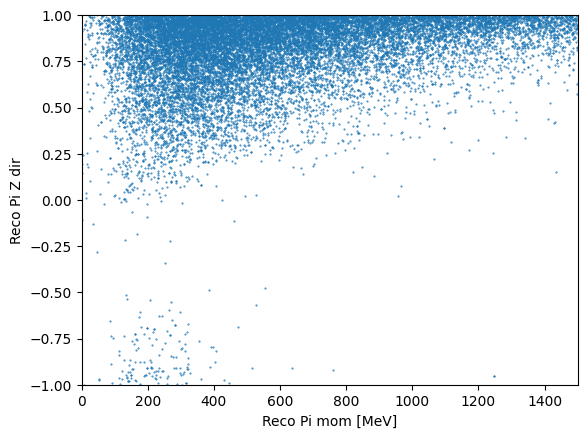

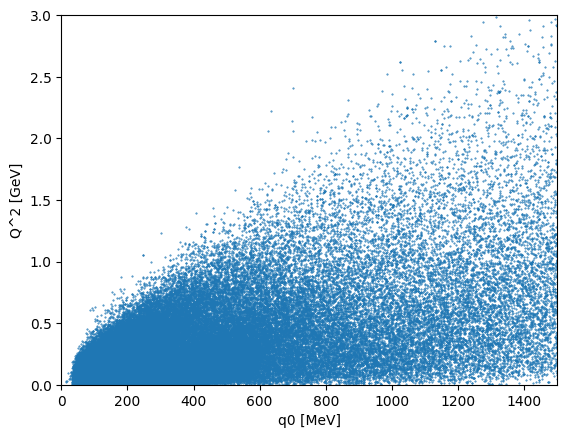

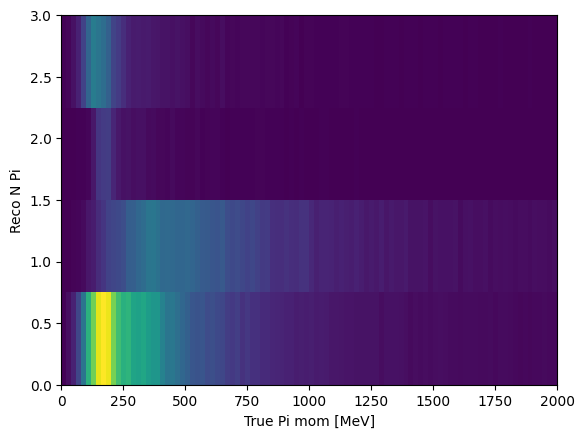

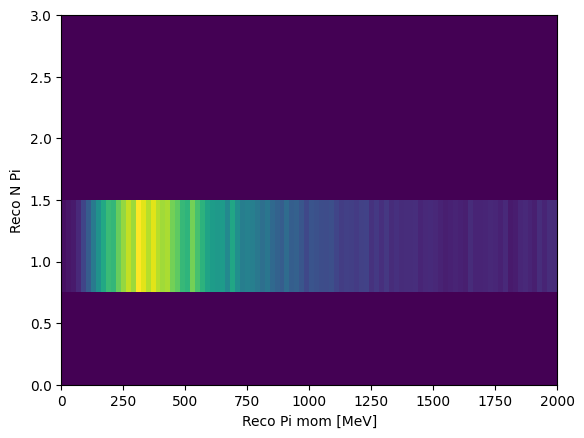

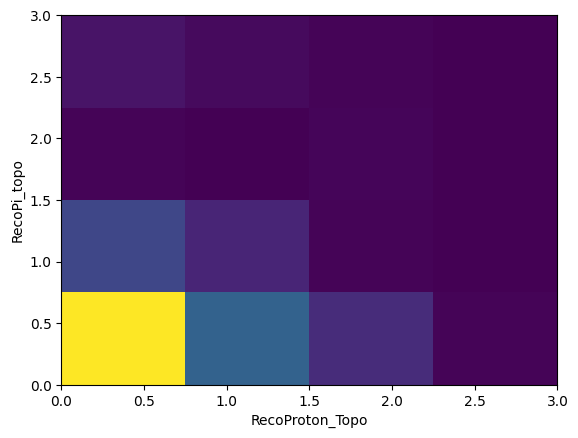

In [5]:
with uproot.open('~/Downloads/FDS_run2air_v1.root') as file:

    sample_sum = file['sample_sum'].arrays(
        filter_branch=lambda b: b.name.find("Graph") == -1 and b.typename.find("std::vector") == -1,
        library='pd'
    )

    print (":::::: Available branches ::::::::")

    for branch in file['sample_sum'].branches:
        print(f'  - {branch.name}: {branch.typename}')

    plt.scatter(sample_sum["RecoPiMom"], sample_sum["RecoPiDirZ"], s=0.2)
    plt.xlabel("Reco Pi mom [MeV]")
    plt.ylabel("Reco Pi Z dir")
    plt.ylim(-1, 1)
    plt.xlim(0, 1500)
    plt.show()


    plt.scatter(sample_sum["q0"], sample_sum["Q2"], s=0.2)
    plt.xlabel("q0 [MeV]")
    plt.ylabel("Q^2 [GeV]")
    plt.ylim(0, 3)
    plt.xlim(0, 1500)
    plt.show()

    plt.hist2d(sample_sum["TruePostFSIPiMom"], sample_sum["RecoPi_Topo"], bins=(100, 4), range=[(0,2000), (0,3)])
    plt.xlabel("True Pi mom [MeV]")
    plt.ylabel("Reco N Pi")
    plt.show()

    plt.hist2d(sample_sum["RecoPiMom"], sample_sum["RecoPi_Topo"], bins=(100, 4), range=[(0,2000), (0,3)])
    plt.xlabel("Reco Pi mom [MeV]")
    plt.ylabel("Reco N Pi")
    plt.show()

    plt.hist2d(sample_sum["RecoProton_Topo"], sample_sum["RecoPi_Topo"], bins=(4,4))
    plt.xlabel("RecoProton_Topo")
    plt.ylabel("RecoPi_topo")
    plt.show()

In [6]:

class nd280EventDataset(Dataset):
    def __init__(self, root, filenames:list[str], branches:list[str], branch_scaling, branch_mask_vals, branch_mask_replace_vals, use_masked_tensor:bool=False, filter:str=None):
        super().__init__()

        self.root = root
        self._raw_filenames = filenames
        self._branches = branches
        self._branch_mask_vals = branch_mask_vals
        self._branch_scaling = branch_scaling
        self._branch_mask_replace_vals = torch.tensor(branch_mask_replace_vals)
        self._processed_filenames = []
        self._filter = filter

        self.use_masked_tensor = use_masked_tensor

    def get_n_features(self):
        return len(self._branches)

    def process(self):

        event_idx = 0

        # go through each raw file
        for raw_filename in self._raw_filenames:
            # open the file
            with uproot.open(raw_filename) as file:

                # get the sample_sum tree as a pandas array
                sample_sum = file['sample_sum'].arrays(
                    filter_branch=lambda b: b.name.find("Graph") == -1 and b.name.find("True") == -1 and b.typename.find("std::vector") == -1,
                    library='pd',
                    cut = self._filter
                )

                for _, row in sample_sum[self._branches].iterrows():
    
                    event_tensor:torch.Tensor = torch.tensor(row.values.astype(np.float32))
                    event_tensor = torch.clip(event_tensor, min = -1.0, max = 5000)
                    event_tensor *= self._branch_scaling

                    to_mask = row.values.astype(np.float32) == self._branch_mask_vals
                    event_tensor[to_mask] = self._branch_mask_replace_vals[to_mask]

                    if self.use_masked_tensor:
                        mask = torch.tensor(row.values.astype(np.float32) != self._branch_mask_vals)
                        event_tensor:torch.masked.MaskedTensor = masked.masked_tensor(event_tensor, mask)

                    filename = os.path.join(self.root, f'event_{event_idx}_proc.pt')
                    
                    self._processed_filenames.append(filename)
                    torch.save(event_tensor, filename)

                    if event_idx %10000 == 0:
                        print(f"Processed {event_idx} events")

                    event_idx += 1

    def __len__(self):
        return len(self._processed_filenames)


    def __getitem__(self, index):
        with torch.serialization.safe_globals([masked.MaskedTensor]):
            event = torch.load(os.path.join(self.root, f'event_{index}_proc.pt'))
        return event, event
    
train_ds = nd280EventDataset(
    root="/home/ewan/ND280-ML/fancy-data-MC-comparisons/processed_files/MC",
    filenames=['/home/ewan/Downloads/FDS_run2air_v1.root', '/home/ewan/Downloads/FDS_run5water_v1.root '],
    branches=["Pmu", "CosThetamu", "RecoPiMom", "RecoPiDirZ", "RecoProtonMom", "RecoProtonDirZ", "RecoPi_Topo", "RecoProton_Topo"],
    branch_scaling=np.array([0.2e-3, 1.0, 0.2e-3, 1.0, 0.2e-3, 1.0, 1/3.0, 1/3.0], dtype=np.float32),
    branch_mask_vals=np.array([-999.0, -999.0, -999.0, -999.0, -999.0, -999.0, -999.0, -999.0]),
    branch_mask_replace_vals=np.array([0.0, -1.0, 0.0, -1.0, 0.0, -1.0, -1.0, -1.0], dtype=np.float32),
    filter="q0<2000.0" #"isSRC!=1"
)

ood_ds = nd280EventDataset(
    root="/home/ewan/ND280-ML/fancy-data-MC-comparisons/processed_files/MC_src",
    filenames=['/home/ewan/Downloads/FDS_run2air_v1.root', '/home/ewan/Downloads/FDS_run5water_v1.root '],
    branches=["Pmu", "CosThetamu", "RecoPiMom", "RecoPiDirZ", "RecoProtonMom", "RecoProtonDirZ", "RecoPi_Topo", "RecoProton_Topo"],
    branch_scaling=np.array([0.2e-3, 1.0, 0.2e-3, 1.0, 0.2e-3, 1.0, 1/3.0, 1/3.0], dtype=np.float32),
    branch_mask_vals=np.array([-999.0, -999.0, -999.0, -999.0, -999.0, -999.0, -999.0, -999.0]),
    branch_mask_replace_vals=np.array([0.0, -1.0, 0.0, -1.0, 0.0, -1.0, -1.0, -1.0], dtype=np.float32),
    filter="q0>= 2000.0" #"isSRC==1"
)

train_ds.process()
ood_ds.process()


/tmp/ipykernel_10026/563897299.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  event_tensor *= self._branch_scaling


Processed 0 events
Processed 10000 events
Processed 20000 events
Processed 30000 events
Processed 40000 events
Processed 50000 events
Processed 60000 events
Processed 70000 events
Processed 80000 events
Processed 90000 events
Processed 100000 events
Processed 110000 events


/tmp/ipykernel_10026/563897299.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  event_tensor *= self._branch_scaling


Processed 120000 events
Processed 130000 events
Processed 140000 events
Processed 150000 events
Processed 160000 events
Processed 170000 events
Processed 180000 events
Processed 190000 events


/tmp/ipykernel_10026/563897299.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  event_tensor *= self._branch_scaling


Processed 0 events
Processed 10000 events
Processed 20000 events


/tmp/ipykernel_10026/563897299.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  event_tensor *= self._branch_scaling


Processed 30000 events


Number of training examples: 193345
Number of OOD examples:      32172

##### Making ID and OOD raw distributions ######


48it [00:19,  2.44it/s]                        
8it [00:03,  2.50it/s]                       


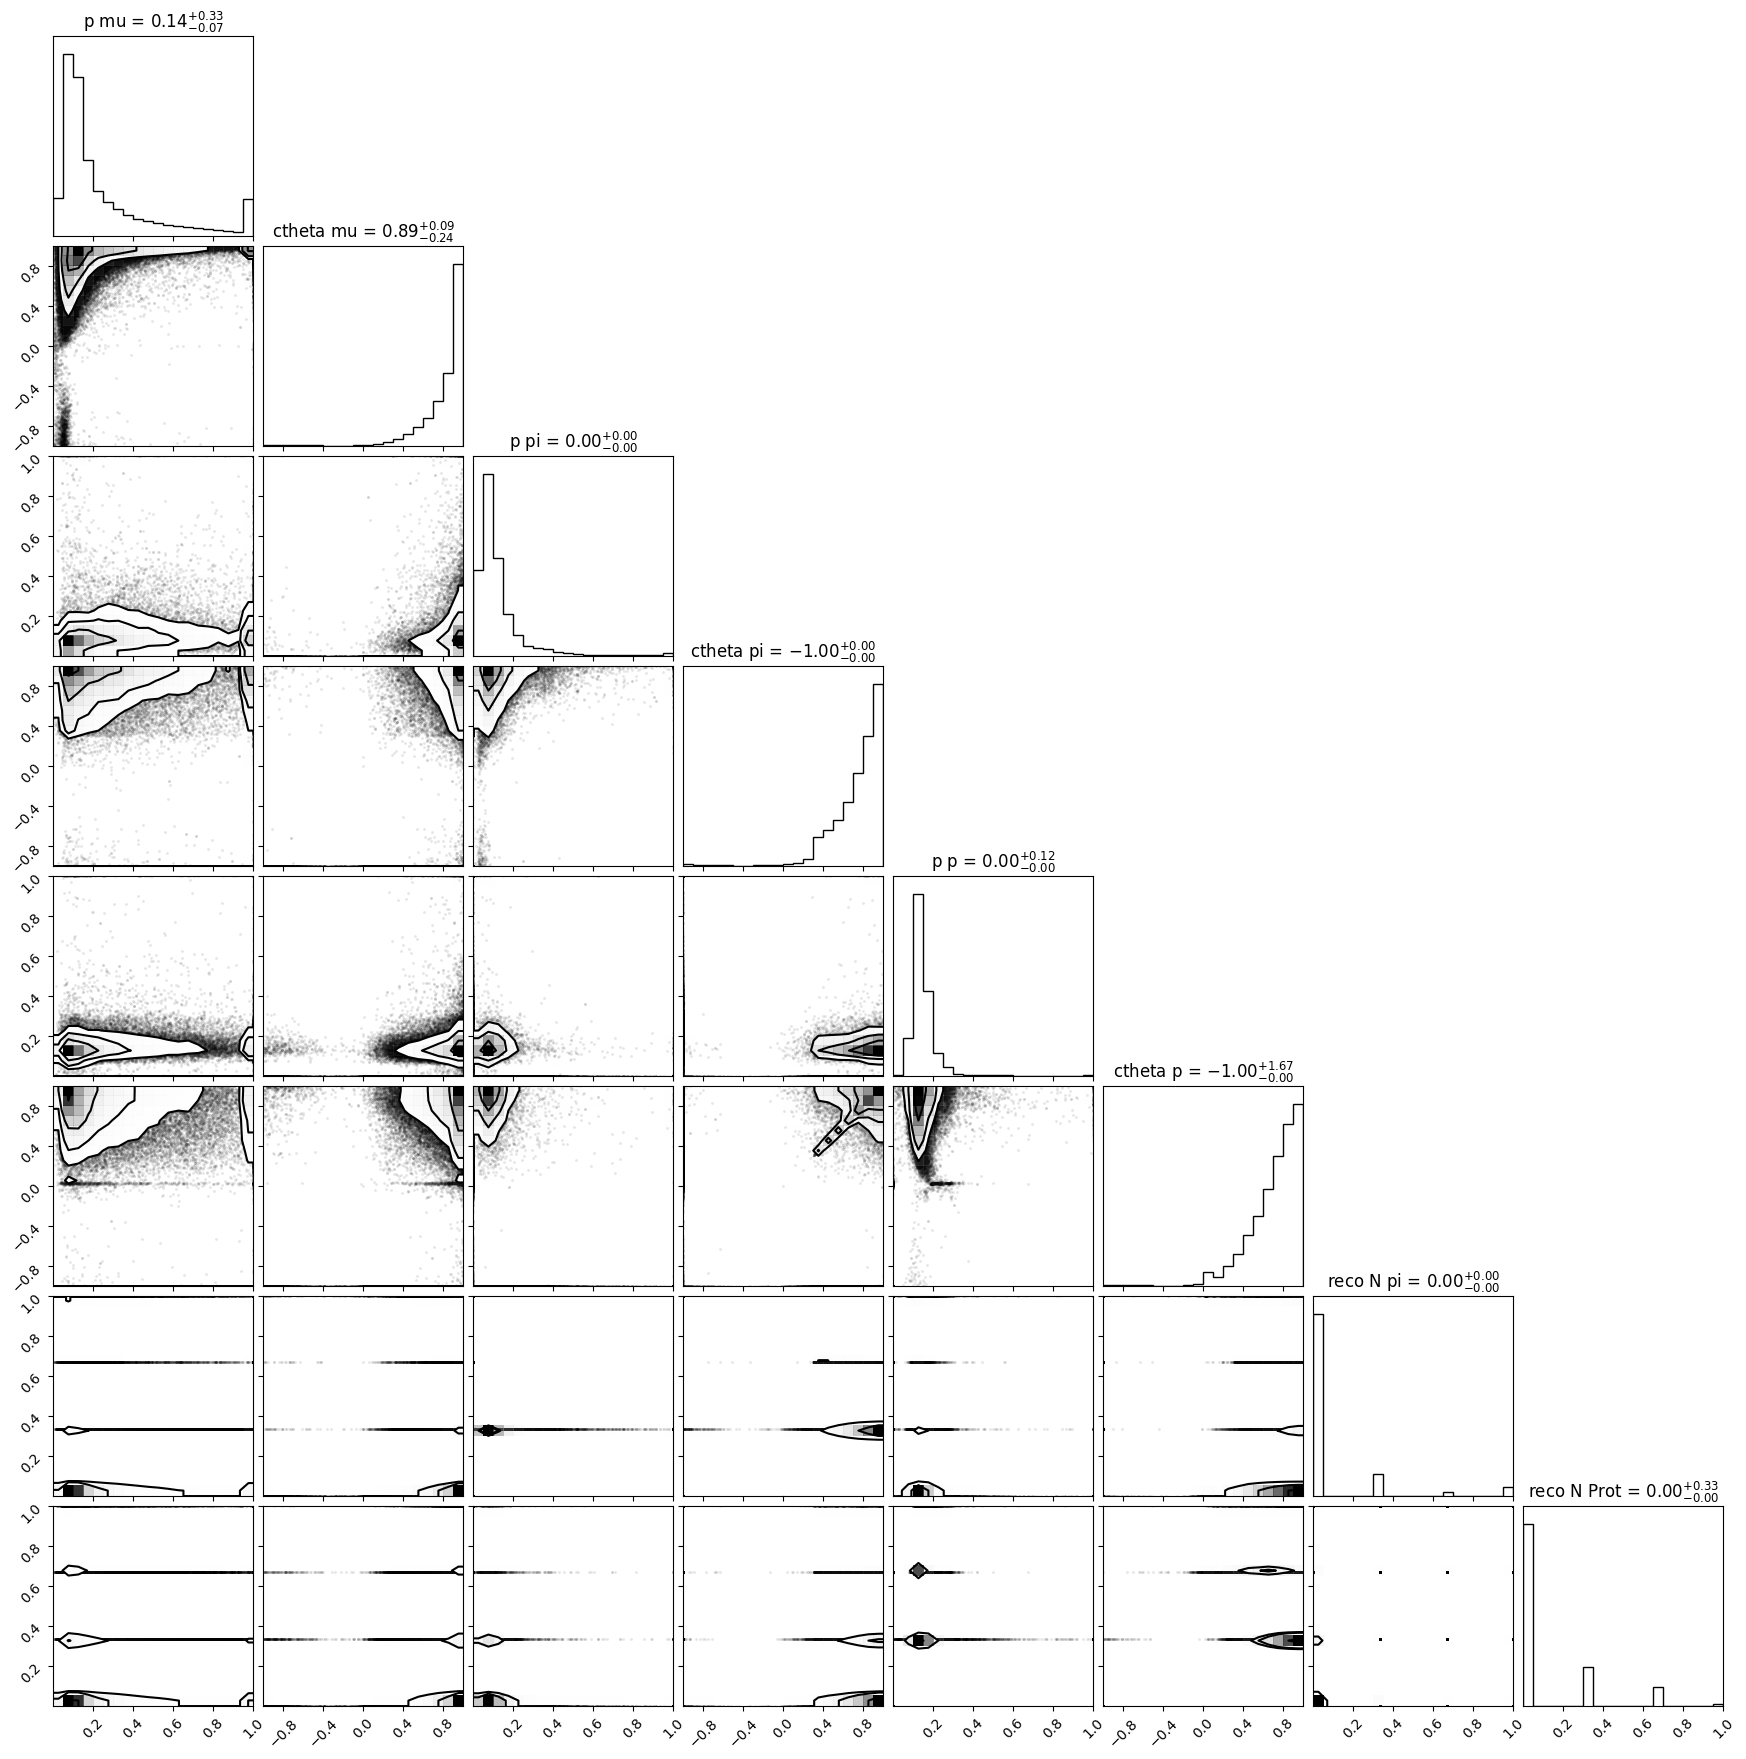

In [7]:
print(f'Number of training examples: {len(train_ds)}')
print(f'Number of OOD examples:      {len(ood_ds)}')


raw_dist = np.ndarray((1, train_ds.get_n_features()))
ood_dist = np.ndarray((1, ood_ds.get_n_features()))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print()
print("##### Making ID and OOD raw distributions ######")

train_loader = DataLoader(train_ds, batch_size=4096, shuffle=True)
progressbar = tqdm(enumerate(train_loader), total=len(train_loader)-1)
for batch_n, (x, n) in progressbar:
    x = x.to(device)
    raw_dist = np.concatenate((raw_dist, x), axis=0)
    progressbar.update()

ood_loader = DataLoader(ood_ds, batch_size=4096, shuffle=True)
progressbar = tqdm(enumerate(ood_loader), total=len(ood_loader)-1)
for batch_n, (x, n) in progressbar:
    ood_dist = np.concatenate((ood_dist, x), axis=0)
    progressbar.update()

figure = corner.corner(
    raw_dist, 
    range = [(0.001, 1), (-0.999,1), (0.001, 1), (-0.999,1), (0.001, 1), (-0.999,1), (0, 1.0), (0, 1.0)],
    titles = ["p mu", "ctheta mu", "p pi", "ctheta pi", "p p", "ctheta p", "reco N pi", "reco N Prot"],
    show_titles = True,
    plot_contours = True,
    hist2d_kwargs = {"no_fill_contours": True}
)
#corner.overplot_points(figure, ood_dist)

plt.show()

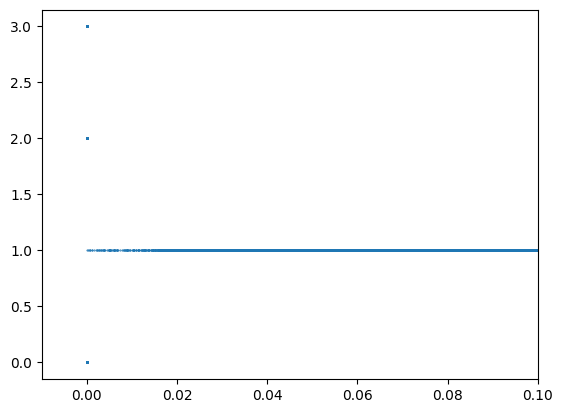

In [8]:
plt.scatter(raw_dist[:, 2], raw_dist[:, 6] * 3.0, s=0.2)
plt.xlim((-0.01, 0.1))
plt.show()

In [9]:
_get_even = lambda xs: xs[:,0::2]
_get_odd = lambda xs: xs[:,1::2]

def _interleave(first, second, order):
    """
    Given 2 rank-2 tensors with same batch dimension, interleave their columns.
    
    The tensors "first" and "second" are assumed to be of shape (B,M) and (B,N)
    where M = N or N+1, repsectively.
    """
    cols = []
    if order == 'even':
        for k in range(second.shape[1]):
            cols.append(first[:,k])
            cols.append(second[:,k])
        if first.shape[1] > second.shape[1]:
            cols.append(first[:,-1])
    else:
        for k in range(first.shape[1]):
            cols.append(second[:,k])
            cols.append(first[:,k])
        if second.shape[1] > first.shape[1]:
            cols.append(second[:,-1])
    return torch.stack(cols, dim=1)


class _BaseCouplingLayer(nn.Module):
    def __init__(self, dim, partition, nonlinearity):
        """
        Base coupling layer that handles the permutation of the inputs and wraps
        an instance of torch.nn.Module.

        Usage:
        >> layer = AdditiveCouplingLayer(1000, 'even', nn.Sequential(...))
        
        Args:
        * dim: dimension of the inputs.
        * partition: str, 'even' or 'odd'. If 'even', the even-valued columns are sent to
        pass through the activation module.
        * nonlinearity: an instance of torch.nn.Module.
        """
        super(_BaseCouplingLayer, self).__init__()
        # store input dimension of incoming values:
        self.dim = dim
        # store partition choice and make shorthands for 1st and second partitions:
        assert (partition in ['even', 'odd']), "[_BaseCouplingLayer] Partition type must be `even` or `odd`!"

        self.partition = partition
        
        if (partition == 'even'):
            self._first = _get_even
            self._second = _get_odd
        else:
            self._first = _get_odd
            self._second = _get_even
        
        # store nonlinear function module:
        # (n.b. this can be a complex instance of torch.nn.Module, for ex. a deep ReLU network)
        self.add_module('nonlinearity', nonlinearity)

    def forward(self, x):
        """Map an input through the partition and nonlinearity."""
        return _interleave(
            self._first(x),
            self.coupling_law(self._second(x), self.nonlinearity(self._first(x))),
            self.partition
        )

    def inverse(self, y):
        """Inverse mapping through the layer. Gradients should be turned off for this pass."""
        return _interleave(
            self._first(y),
            self.anticoupling_law(self._second(y), self.nonlinearity(self._first(y))),
            self.partition
        )

    def coupling_law(self, a, b):
        # (a,b) --> g(a,b)
        raise NotImplementedError("[_BaseCouplingLayer] Don't call abstract base layer!")

    def anticoupling_law(self, a, b):
        # (a,b) --> g^{-1}(a,b)
        raise NotImplementedError("[_BaseCouplingLayer] Don't call abstract base layer!")


class AdditiveCouplingLayer(_BaseCouplingLayer):
    """Layer with coupling law g(a;b) := a + b."""
    def coupling_law(self, a, b):
        return (a + b)
    
    def anticoupling_law(self, a, b):
        return (a - b)


class MultiplicativeCouplingLayer(_BaseCouplingLayer):
    """Layer with coupling law g(a;b) := a .* b."""
    def coupling_law(self, a, b):
        return torch.mul(a,b)
    
    def anticoupling_law(self, a, b):
        return torch.mul(a, torch.reciprocal(b))

In [10]:
n_features = train_ds.get_n_features()
n_bottleneck = 2

hidden_units_encoder = [n_features, 8, 4, n_bottleneck*2]
hidden_units_decoder = [n_bottleneck, 4, 8, n_features]

n_flows = 0
flow_type = "Planar"

print(f"Number of event features: {n_features}")

###########################
## Set up VAE Flow model ##
###########################
prior = torch.distributions.MultivariateNormal(torch.zeros(n_bottleneck, device=device),
                                               torch.eye(n_bottleneck, device=device))
encoder_nn = nf.nets.MLP(hidden_units_encoder)
encoder = nf.distributions.NNDiagGaussian(encoder_nn)
decoder_nn = nf.nets.MLP(hidden_units_decoder)
decoder = nf.distributions.NNBernoulliDecoder(decoder_nn)

if flow_type == 'Planar':
    flows = [nf.flows.Planar((n_bottleneck,)) for k in range(n_flows)]
elif flow_type == 'Radial':
    flows = [nf.flows.Radial((n_bottleneck,)) for k in range(n_flows)]
elif flow_type == 'RealNVP':
    b = torch.tensor(n_bottleneck // 2 * [0, 1] + n_bottleneck % 2 * [0])
    flows = []
    for i in range(n_flows):
        s = nf.nets.MLP([n_bottleneck, n_bottleneck])
        t = nf.nets.MLP([n_bottleneck, n_bottleneck])
        if i % 2 == 0:
            flows += [nf.flows.MaskedAffineFlow(b, t, s)]
        else:
            flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]
else:
    raise NotImplementedError

######################
## set up VAE model ##
######################
class VAE(nn.Module):
    def __init__(self, n_features, latent_size):
        super().__init__()

        self._n_features = n_features
        self._latent_size = latent_size

        self.encode = nn.Sequential(
            nn.Linear(self._n_features, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
        )

        self.f1 = nn.Linear(256, self._latent_size)
        self.f2 = nn.Linear(256, self._latent_size)
        
        self.decode = nn.Sequential(
            nn.Linear(self._latent_size, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, self._n_features),
        )

    def forward(self, x):
        # Encode

        mu = self.f1( self.encode(x) )
        log_var = self.f2(self.encode(x))

        # Reparametrize variables
        std = torch.exp(0.5 * log_var)
        norm_scale = torch.randn_like(std) + 0.00001
        z_ = mu + norm_scale * std

        # Q0 and prior
        q0 = Normal(mu, torch.exp((0.5 * log_var)))
        p = Normal(0.0, 1.0)

        # Decode
        z_ = z_.view(z_.size(0), self._latent_size)
        zD = self.decode(z_)
        out = zD

        return out, mu, log_var

class NICEModel(nn.Module):
    def __init__(self, n_features:int, n_flows:int, n_hidden:list[int], *args, **kwargs):
        super().__init__(*args, **kwargs)

        coupling_layers = []
        for i_flow in range(n_flows):

            if i_flow %2 == 0:
                part = "even"
            else:
                part = "odd"

            half_features = -999
            if part == "even":
                half_features = m.ceil(n_features / 2)
            else:
                half_features = m.floor(n_features / 2)

            # build the list of shift layers 
            shift_layers = []

            shift_layers.append(nn.Linear(half_features, n_hidden[0]))
            shift_layers.append(nn.ReLU(True))

            for i_hidden in range(1, len(n_hidden)):
                shift_layers.append(nn.Linear(n_hidden[i_hidden-1], n_hidden[i_hidden]))
                shift_layers.append(nn.ReLU(True))

            shift_layers.append( nn.Linear(n_hidden[-1], half_features))


            # add the affine layer, made from those shift layers
            coupling_layers.append(
                AdditiveCouplingLayer(
                    dim = n_features,
                    partition = part,
                    nonlinearity = nn.Sequential(*shift_layers)
                )
            )


        self.flows = nn.Sequential(*coupling_layers)
    
        self.scaling_diag = nn.Parameter(torch.ones(n_features))

    def forward(self, x):
        
        y = self.flows(x)

        return torch.matmul(y, torch.diag(torch.exp(self.scaling_diag)))
    
    def inverse(self, y):
        """Invert a set of draws from gaussians"""
        with torch.no_grad():
            x = torch.matmul(y, torch.diag(torch.reciprocal(torch.exp(self.scaling_diag))))
            
            for flow in self.flows:
                x = flow.inverse(x)
            
        return x

def NICE_gaussian_loss(h, diag, keepdim=False):
    return torch.sum(diag) - (0.5*torch.sum(torch.pow(h,2),dim=1,keepdim=keepdim) + h.size(1)*0.5*torch.log(torch.tensor(2*np.pi)))

# wrap above loss functions in Modules:
class GaussianPriorNICELoss(nn.Module):
    def __init__(self, size_average=True):
        super(GaussianPriorNICELoss, self).__init__()
        self.size_average = size_average

    def forward(self, fx, diag):
        if self.size_average:
            return torch.mean(-NICE_gaussian_loss(fx, diag))
        else:
            return torch.sum(-NICE_gaussian_loss(fx, diag))

#model = VAE(6, 2) 
#model = nf.NormalizingFlowVAE(prior, encoder, flows, decoder)
model = NICEModel(n_features, 5, [64, 128, 256, 128, 64])

model.to(device)

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

model.compile()
model.train()

print("##### Model #####'")
for module in model.modules():
    print(module)

print(f"trainable parameters: {params}")

Number of event features: 8
##### Model #####'
NICEModel(
  (flows): Sequential(
    (0): AdditiveCouplingLayer(
      (nonlinearity): Sequential(
        (0): Linear(in_features=4, out_features=64, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=64, out_features=128, bias=True)
        (3): ReLU(inplace=True)
        (4): Linear(in_features=128, out_features=256, bias=True)
        (5): ReLU(inplace=True)
        (6): Linear(in_features=256, out_features=128, bias=True)
        (7): ReLU(inplace=True)
        (8): Linear(in_features=128, out_features=64, bias=True)
        (9): ReLU(inplace=True)
        (10): Linear(in_features=64, out_features=4, bias=True)
      )
    )
    (1): AdditiveCouplingLayer(
      (nonlinearity): Sequential(
        (0): Linear(in_features=4, out_features=64, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=64, out_features=128, bias=True)
        (3): ReLU(inplace=True)
        (4): Linear(in_features=

In [11]:
n_epochs = 300
log_intv = 100
num_samples = 64

train_loader:DataLoader = DataLoader(train_ds, batch_size=4096, shuffle=True)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

# Train VAE Flow model
if isinstance(model, nf.NormalizingFlowVAE):
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        progressbar = tqdm(enumerate(train_loader), total=len(train_loader))
        for batch_n, (x, n) in progressbar:
            x = x.to(device)
            optimizer.zero_grad()
            z, log_q, log_p = model(x, num_samples)
            mean_log_q = torch.mean(log_q)
            mean_log_p = torch.mean(log_p)
            loss = mean_log_q - mean_log_p
            loss.backward()
            optimizer.step()
            progressbar.update()
        progressbar.close()
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_n * len(x), len(train_loader.dataset),
                        100. * batch_n / len(train_loader),
                        loss.item()))
    
# Train VAE model
if isinstance(model, VAE):
    for epoch in range(n_epochs):
        progressbar = tqdm(enumerate(train_loader), total=len(train_loader))
        for batch_n, (x, n) in progressbar:
            x = x.to(device)
            optimizer.zero_grad()
            rc_batch, mu, log_var = model(x)
            loss = MSELoss()(x, rc_batch)
            loss.backward()
            optimizer.step()
            progressbar.update()
            if batch_n % log_intv == 0:
                print(
                    "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                        epoch,
                        batch_n * len(x),
                        len(train_loader.dataset),
                        100.0 * batch_n / len(train_loader),
                        loss.item() / len(x),
                    )
                )

# Train NICE model:
if isinstance(model, NICEModel):

    gauss_loss = GaussianPriorNICELoss()
    def loss_fn(model_pred):
        return gauss_loss(model_pred, model.scaling_diag)
    
    for epoch in range(n_epochs):
        progressbar = tqdm(enumerate(train_loader), total=len(train_loader))
        for batch_n, (x, n) in progressbar:
            x = x.to(device)
            optimizer.zero_grad()
            enc = model(x)
            loss = loss_fn(enc)
            loss.backward()
            optimizer.step()
            
            progressbar.update()
        progressbar.close()
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_n * len(x), len(train_loader.dataset),
                        100. * batch_n / len(train_loader),
                        loss.item()))

  0%|          | 0/48 [00:00<?, ?it/s]/home/ewan/ND280-ML/fancy-data-MC-comparisons/data-MC-comp-env/lib/python3.12/site-packages/torch/_inductor/lowering.py:1625: FutureWarning: `torch._prims_common.check` is deprecated and will be removed in the future. Please use `torch._check*` functions instead.
  check(
57it [00:44,  1.94it/s]                        /home/ewan/ND280-ML/fancy-data-MC-comparisons/data-MC-comp-env/lib/python3.12/site-packages/torch/_inductor/lowering.py:1625: FutureWarning: `torch._prims_common.check` is deprecated and will be removed in the future. Please use `torch._check*` functions instead.
  check(
100%|██████████| 48/48 [00:54<00:00,  1.14s/it]


Train Epoch: 0 [39151/193345 (98%)]	Loss: 5.797210


100%|██████████| 48/48 [00:22<00:00,  2.15it/s]


Train Epoch: 1 [39151/193345 (98%)]	Loss: 3.202764


100%|██████████| 48/48 [00:21<00:00,  2.21it/s]


Train Epoch: 2 [39151/193345 (98%)]	Loss: 3.075387


100%|██████████| 48/48 [00:21<00:00,  2.22it/s]


Train Epoch: 3 [39151/193345 (98%)]	Loss: 1.266426


100%|██████████| 48/48 [00:21<00:00,  2.21it/s]


Train Epoch: 4 [39151/193345 (98%)]	Loss: 0.251835


100%|██████████| 48/48 [00:21<00:00,  2.23it/s]


Train Epoch: 5 [39151/193345 (98%)]	Loss: -0.046343


100%|██████████| 48/48 [00:21<00:00,  2.20it/s]


Train Epoch: 6 [39151/193345 (98%)]	Loss: -0.231718


100%|██████████| 48/48 [00:21<00:00,  2.21it/s]


Train Epoch: 7 [39151/193345 (98%)]	Loss: -0.302561


100%|██████████| 48/48 [00:21<00:00,  2.21it/s]


Train Epoch: 8 [39151/193345 (98%)]	Loss: -0.435883


100%|██████████| 48/48 [00:21<00:00,  2.20it/s]


Train Epoch: 9 [39151/193345 (98%)]	Loss: -0.542234


100%|██████████| 48/48 [00:21<00:00,  2.21it/s]


Train Epoch: 10 [39151/193345 (98%)]	Loss: -0.684446


100%|██████████| 48/48 [00:21<00:00,  2.19it/s]


Train Epoch: 11 [39151/193345 (98%)]	Loss: -0.743617


100%|██████████| 48/48 [00:21<00:00,  2.20it/s]


Train Epoch: 12 [39151/193345 (98%)]	Loss: -0.807615


100%|██████████| 48/48 [00:20<00:00,  2.29it/s]


Train Epoch: 13 [39151/193345 (98%)]	Loss: -0.851741


100%|██████████| 48/48 [00:22<00:00,  2.16it/s]


Train Epoch: 14 [39151/193345 (98%)]	Loss: -0.896563


100%|██████████| 48/48 [00:21<00:00,  2.18it/s]


Train Epoch: 15 [39151/193345 (98%)]	Loss: -0.936839


100%|██████████| 48/48 [00:22<00:00,  2.18it/s]


Train Epoch: 16 [39151/193345 (98%)]	Loss: -0.996354


100%|██████████| 48/48 [00:22<00:00,  2.18it/s]


Train Epoch: 17 [39151/193345 (98%)]	Loss: -1.052774


100%|██████████| 48/48 [00:21<00:00,  2.20it/s]


Train Epoch: 18 [39151/193345 (98%)]	Loss: -1.080258


100%|██████████| 48/48 [00:22<00:00,  2.17it/s]


Train Epoch: 19 [39151/193345 (98%)]	Loss: -1.140424


100%|██████████| 48/48 [00:22<00:00,  2.16it/s]


Train Epoch: 20 [39151/193345 (98%)]	Loss: -1.159755


100%|██████████| 48/48 [00:22<00:00,  2.15it/s]


Train Epoch: 21 [39151/193345 (98%)]	Loss: -1.195689


100%|██████████| 48/48 [00:22<00:00,  2.15it/s]


Train Epoch: 22 [39151/193345 (98%)]	Loss: -1.258364


100%|██████████| 48/48 [00:22<00:00,  2.15it/s]


Train Epoch: 23 [39151/193345 (98%)]	Loss: -1.306734


100%|██████████| 48/48 [00:22<00:00,  2.17it/s]


Train Epoch: 24 [39151/193345 (98%)]	Loss: -1.327315


100%|██████████| 48/48 [00:22<00:00,  2.14it/s]


Train Epoch: 25 [39151/193345 (98%)]	Loss: -1.381913


100%|██████████| 48/48 [00:22<00:00,  2.16it/s]


Train Epoch: 26 [39151/193345 (98%)]	Loss: -1.432969


100%|██████████| 48/48 [00:22<00:00,  2.15it/s]


Train Epoch: 27 [39151/193345 (98%)]	Loss: -1.467947


100%|██████████| 48/48 [00:22<00:00,  2.11it/s]


Train Epoch: 28 [39151/193345 (98%)]	Loss: -1.479748


100%|██████████| 48/48 [00:22<00:00,  2.09it/s]


Train Epoch: 29 [39151/193345 (98%)]	Loss: -1.528965


100%|██████████| 48/48 [00:23<00:00,  2.00it/s]


Train Epoch: 30 [39151/193345 (98%)]	Loss: -1.541691


100%|██████████| 48/48 [00:26<00:00,  1.82it/s]


Train Epoch: 31 [39151/193345 (98%)]	Loss: -1.606352


100%|██████████| 48/48 [00:30<00:00,  1.59it/s]


Train Epoch: 32 [39151/193345 (98%)]	Loss: -1.638046


100%|██████████| 48/48 [00:32<00:00,  1.49it/s]


Train Epoch: 33 [39151/193345 (98%)]	Loss: -1.687306


100%|██████████| 48/48 [00:33<00:00,  1.43it/s]


Train Epoch: 34 [39151/193345 (98%)]	Loss: -1.724778


100%|██████████| 48/48 [00:34<00:00,  1.37it/s]


Train Epoch: 35 [39151/193345 (98%)]	Loss: -1.775197


100%|██████████| 48/48 [00:35<00:00,  1.35it/s]


Train Epoch: 36 [39151/193345 (98%)]	Loss: -1.817475


100%|██████████| 48/48 [00:36<00:00,  1.32it/s]


Train Epoch: 37 [39151/193345 (98%)]	Loss: -1.845293


100%|██████████| 48/48 [00:37<00:00,  1.28it/s]


Train Epoch: 38 [39151/193345 (98%)]	Loss: -1.897376


100%|██████████| 48/48 [00:38<00:00,  1.25it/s]


Train Epoch: 39 [39151/193345 (98%)]	Loss: -1.943451


100%|██████████| 48/48 [00:39<00:00,  1.20it/s]


Train Epoch: 40 [39151/193345 (98%)]	Loss: -1.978810


100%|██████████| 48/48 [00:40<00:00,  1.19it/s]


Train Epoch: 41 [39151/193345 (98%)]	Loss: -1.975214


100%|██████████| 48/48 [00:40<00:00,  1.17it/s]


Train Epoch: 42 [39151/193345 (98%)]	Loss: -2.040552


100%|██████████| 48/48 [00:41<00:00,  1.15it/s]


Train Epoch: 43 [39151/193345 (98%)]	Loss: -2.045948


100%|██████████| 48/48 [00:42<00:00,  1.14it/s]


Train Epoch: 44 [39151/193345 (98%)]	Loss: -2.115089


100%|██████████| 48/48 [00:42<00:00,  1.12it/s]


Train Epoch: 45 [39151/193345 (98%)]	Loss: -2.162379


100%|██████████| 48/48 [00:43<00:00,  1.10it/s]


Train Epoch: 46 [39151/193345 (98%)]	Loss: -2.197668


100%|██████████| 48/48 [00:44<00:00,  1.09it/s]


Train Epoch: 47 [39151/193345 (98%)]	Loss: -2.234726


100%|██████████| 48/48 [00:44<00:00,  1.07it/s]


Train Epoch: 48 [39151/193345 (98%)]	Loss: -2.264966


100%|██████████| 48/48 [00:45<00:00,  1.06it/s]


Train Epoch: 49 [39151/193345 (98%)]	Loss: -2.290588


100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


Train Epoch: 50 [39151/193345 (98%)]	Loss: -2.314626


100%|██████████| 48/48 [00:46<00:00,  1.03it/s]


Train Epoch: 51 [39151/193345 (98%)]	Loss: -2.393918


100%|██████████| 48/48 [00:46<00:00,  1.03it/s]


Train Epoch: 52 [39151/193345 (98%)]	Loss: -2.442513


100%|██████████| 48/48 [00:47<00:00,  1.02it/s]


Train Epoch: 53 [39151/193345 (98%)]	Loss: -2.466621


100%|██████████| 48/48 [00:48<00:00,  1.02s/it]


Train Epoch: 54 [39151/193345 (98%)]	Loss: -2.494325


100%|██████████| 48/48 [00:49<00:00,  1.02s/it]


Train Epoch: 55 [39151/193345 (98%)]	Loss: -2.540256


100%|██████████| 48/48 [00:49<00:00,  1.03s/it]


Train Epoch: 56 [39151/193345 (98%)]	Loss: -2.576135


100%|██████████| 48/48 [00:50<00:00,  1.05s/it]


Train Epoch: 57 [39151/193345 (98%)]	Loss: -2.620198


100%|██████████| 48/48 [00:51<00:00,  1.08s/it]


Train Epoch: 58 [39151/193345 (98%)]	Loss: -2.640812


100%|██████████| 48/48 [00:51<00:00,  1.08s/it]


Train Epoch: 59 [39151/193345 (98%)]	Loss: -2.695429


100%|██████████| 48/48 [00:52<00:00,  1.09s/it]


Train Epoch: 60 [39151/193345 (98%)]	Loss: -2.720490


100%|██████████| 48/48 [00:52<00:00,  1.08s/it]


Train Epoch: 61 [39151/193345 (98%)]	Loss: -2.771044


100%|██████████| 48/48 [00:52<00:00,  1.10s/it]


Train Epoch: 62 [39151/193345 (98%)]	Loss: -2.771266


100%|██████████| 48/48 [00:53<00:00,  1.12s/it]


Train Epoch: 63 [39151/193345 (98%)]	Loss: -2.805806


100%|██████████| 48/48 [00:54<00:00,  1.14s/it]


Train Epoch: 64 [39151/193345 (98%)]	Loss: -2.826955


100%|██████████| 48/48 [00:53<00:00,  1.12s/it]


Train Epoch: 65 [39151/193345 (98%)]	Loss: -2.881788


100%|██████████| 48/48 [00:54<00:00,  1.14s/it]


Train Epoch: 66 [39151/193345 (98%)]	Loss: -2.981266


100%|██████████| 48/48 [00:55<00:00,  1.15s/it]


Train Epoch: 67 [39151/193345 (98%)]	Loss: -2.995452


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]


Train Epoch: 68 [39151/193345 (98%)]	Loss: -3.038029


100%|██████████| 48/48 [00:57<00:00,  1.19s/it]


Train Epoch: 69 [39151/193345 (98%)]	Loss: -3.048790


100%|██████████| 48/48 [00:57<00:00,  1.20s/it]


Train Epoch: 70 [39151/193345 (98%)]	Loss: -2.603918


100%|██████████| 48/48 [00:57<00:00,  1.20s/it]


Train Epoch: 71 [39151/193345 (98%)]	Loss: -3.129854


100%|██████████| 48/48 [00:58<00:00,  1.21s/it]


Train Epoch: 72 [39151/193345 (98%)]	Loss: -3.170907


100%|██████████| 48/48 [00:57<00:00,  1.20s/it]


Train Epoch: 73 [39151/193345 (98%)]	Loss: -3.239672


100%|██████████| 48/48 [00:57<00:00,  1.20s/it]


Train Epoch: 74 [39151/193345 (98%)]	Loss: -3.261248


100%|██████████| 48/48 [00:58<00:00,  1.21s/it]


Train Epoch: 75 [39151/193345 (98%)]	Loss: -3.296735


100%|██████████| 48/48 [00:59<00:00,  1.24s/it]


Train Epoch: 76 [39151/193345 (98%)]	Loss: -3.362830


100%|██████████| 48/48 [01:00<00:00,  1.26s/it]


Train Epoch: 77 [39151/193345 (98%)]	Loss: -3.374453


100%|██████████| 48/48 [01:01<00:00,  1.28s/it]


Train Epoch: 78 [39151/193345 (98%)]	Loss: -3.404205


100%|██████████| 48/48 [01:01<00:00,  1.27s/it]


Train Epoch: 79 [39151/193345 (98%)]	Loss: -3.461328


100%|██████████| 48/48 [01:01<00:00,  1.28s/it]


Train Epoch: 80 [39151/193345 (98%)]	Loss: -3.468074


100%|██████████| 48/48 [01:01<00:00,  1.28s/it]


Train Epoch: 81 [39151/193345 (98%)]	Loss: -3.512582


100%|██████████| 48/48 [01:02<00:00,  1.29s/it]


Train Epoch: 82 [39151/193345 (98%)]	Loss: -3.558355


100%|██████████| 48/48 [01:02<00:00,  1.31s/it]


Train Epoch: 83 [39151/193345 (98%)]	Loss: -3.617672


100%|██████████| 48/48 [01:00<00:00,  1.26s/it]


Train Epoch: 84 [39151/193345 (98%)]	Loss: -3.653368


100%|██████████| 48/48 [00:58<00:00,  1.22s/it]


Train Epoch: 85 [39151/193345 (98%)]	Loss: -3.663790


100%|██████████| 48/48 [00:58<00:00,  1.23s/it]


Train Epoch: 86 [39151/193345 (98%)]	Loss: -3.725160


100%|██████████| 48/48 [00:58<00:00,  1.23s/it]


Train Epoch: 87 [39151/193345 (98%)]	Loss: -3.756464


100%|██████████| 48/48 [00:59<00:00,  1.25s/it]


Train Epoch: 88 [39151/193345 (98%)]	Loss: -3.790698


100%|██████████| 48/48 [01:01<00:00,  1.28s/it]


Train Epoch: 89 [39151/193345 (98%)]	Loss: -3.856043


100%|██████████| 48/48 [01:02<00:00,  1.31s/it]


Train Epoch: 90 [39151/193345 (98%)]	Loss: -3.771046


100%|██████████| 48/48 [01:03<00:00,  1.33s/it]


Train Epoch: 91 [39151/193345 (98%)]	Loss: -3.919656


100%|██████████| 48/48 [01:03<00:00,  1.32s/it]


Train Epoch: 92 [39151/193345 (98%)]	Loss: -3.974577


100%|██████████| 48/48 [01:03<00:00,  1.32s/it]


Train Epoch: 93 [39151/193345 (98%)]	Loss: -4.004304


100%|██████████| 48/48 [01:04<00:00,  1.33s/it]


Train Epoch: 94 [39151/193345 (98%)]	Loss: -4.008151


100%|██████████| 48/48 [01:04<00:00,  1.34s/it]


Train Epoch: 95 [39151/193345 (98%)]	Loss: -4.093026


100%|██████████| 48/48 [01:05<00:00,  1.36s/it]


Train Epoch: 96 [39151/193345 (98%)]	Loss: -4.080277


100%|██████████| 48/48 [01:04<00:00,  1.35s/it]


Train Epoch: 97 [39151/193345 (98%)]	Loss: -4.172884


100%|██████████| 48/48 [01:04<00:00,  1.34s/it]


Train Epoch: 98 [39151/193345 (98%)]	Loss: -4.170398


100%|██████████| 48/48 [01:05<00:00,  1.37s/it]


Train Epoch: 99 [39151/193345 (98%)]	Loss: -4.224883


100%|██████████| 48/48 [01:06<00:00,  1.38s/it]


Train Epoch: 100 [39151/193345 (98%)]	Loss: -4.257224


100%|██████████| 48/48 [01:07<00:00,  1.40s/it]


Train Epoch: 101 [39151/193345 (98%)]	Loss: -4.301073


100%|██████████| 48/48 [01:07<00:00,  1.42s/it]


Train Epoch: 102 [39151/193345 (98%)]	Loss: -4.198452


100%|██████████| 48/48 [01:08<00:00,  1.42s/it]


Train Epoch: 103 [39151/193345 (98%)]	Loss: -4.352802


100%|██████████| 48/48 [01:09<00:00,  1.45s/it]


Train Epoch: 104 [39151/193345 (98%)]	Loss: -4.403160


100%|██████████| 48/48 [01:09<00:00,  1.45s/it]


Train Epoch: 105 [39151/193345 (98%)]	Loss: -4.448263


100%|██████████| 48/48 [01:10<00:00,  1.46s/it]


Train Epoch: 106 [39151/193345 (98%)]	Loss: -4.486313


100%|██████████| 48/48 [01:10<00:00,  1.46s/it]


Train Epoch: 107 [39151/193345 (98%)]	Loss: -4.503004


100%|██████████| 48/48 [01:10<00:00,  1.46s/it]


Train Epoch: 108 [39151/193345 (98%)]	Loss: -4.543165


100%|██████████| 48/48 [01:11<00:00,  1.48s/it]


Train Epoch: 109 [39151/193345 (98%)]	Loss: -4.594110


100%|██████████| 48/48 [01:12<00:00,  1.51s/it]


Train Epoch: 110 [39151/193345 (98%)]	Loss: -4.649544


100%|██████████| 48/48 [01:13<00:00,  1.54s/it]


Train Epoch: 111 [39151/193345 (98%)]	Loss: -4.672751


100%|██████████| 48/48 [01:14<00:00,  1.55s/it]


Train Epoch: 112 [39151/193345 (98%)]	Loss: -4.686829


100%|██████████| 48/48 [01:15<00:00,  1.56s/it]


Train Epoch: 113 [39151/193345 (98%)]	Loss: -4.766351


100%|██████████| 48/48 [01:15<00:00,  1.57s/it]


Train Epoch: 114 [39151/193345 (98%)]	Loss: -4.768354


100%|██████████| 48/48 [01:16<00:00,  1.60s/it]


Train Epoch: 115 [39151/193345 (98%)]	Loss: -4.844384


100%|██████████| 48/48 [01:16<00:00,  1.60s/it]


Train Epoch: 116 [39151/193345 (98%)]	Loss: -4.763115


100%|██████████| 48/48 [01:17<00:00,  1.62s/it]


Train Epoch: 117 [39151/193345 (98%)]	Loss: -4.874858


100%|██████████| 48/48 [01:18<00:00,  1.64s/it]


Train Epoch: 118 [39151/193345 (98%)]	Loss: -4.941634


100%|██████████| 48/48 [01:18<00:00,  1.64s/it]


Train Epoch: 119 [39151/193345 (98%)]	Loss: -4.967359


100%|██████████| 48/48 [01:16<00:00,  1.59s/it]


Train Epoch: 120 [39151/193345 (98%)]	Loss: -5.010213


100%|██████████| 48/48 [01:12<00:00,  1.52s/it]


Train Epoch: 121 [39151/193345 (98%)]	Loss: -5.040924


100%|██████████| 48/48 [01:10<00:00,  1.48s/it]


Train Epoch: 122 [39151/193345 (98%)]	Loss: -5.099420


100%|██████████| 48/48 [01:12<00:00,  1.50s/it]


Train Epoch: 123 [39151/193345 (98%)]	Loss: -5.129078


100%|██████████| 48/48 [01:13<00:00,  1.53s/it]


Train Epoch: 124 [39151/193345 (98%)]	Loss: -5.140244


100%|██████████| 48/48 [01:13<00:00,  1.54s/it]


Train Epoch: 125 [39151/193345 (98%)]	Loss: -5.226106


100%|██████████| 48/48 [01:13<00:00,  1.54s/it]


Train Epoch: 126 [39151/193345 (98%)]	Loss: -5.239358


100%|██████████| 48/48 [01:14<00:00,  1.56s/it]


Train Epoch: 127 [39151/193345 (98%)]	Loss: -5.295354


100%|██████████| 48/48 [01:14<00:00,  1.55s/it]


Train Epoch: 128 [39151/193345 (98%)]	Loss: -5.333266


100%|██████████| 48/48 [01:14<00:00,  1.56s/it]


Train Epoch: 129 [39151/193345 (98%)]	Loss: -5.283967


100%|██████████| 48/48 [01:15<00:00,  1.57s/it]


Train Epoch: 130 [39151/193345 (98%)]	Loss: -5.411204


100%|██████████| 48/48 [01:14<00:00,  1.56s/it]


Train Epoch: 131 [39151/193345 (98%)]	Loss: -5.444336


100%|██████████| 48/48 [01:15<00:00,  1.56s/it]


Train Epoch: 132 [39151/193345 (98%)]	Loss: -5.476601


100%|██████████| 48/48 [01:15<00:00,  1.57s/it]


Train Epoch: 133 [39151/193345 (98%)]	Loss: -5.472315


100%|██████████| 48/48 [01:14<00:00,  1.55s/it]


Train Epoch: 134 [39151/193345 (98%)]	Loss: -5.417308


100%|██████████| 48/48 [01:14<00:00,  1.55s/it]


Train Epoch: 135 [39151/193345 (98%)]	Loss: -5.575109


100%|██████████| 48/48 [01:15<00:00,  1.56s/it]


Train Epoch: 136 [39151/193345 (98%)]	Loss: -5.617587


100%|██████████| 48/48 [01:15<00:00,  1.57s/it]


Train Epoch: 137 [39151/193345 (98%)]	Loss: -5.678333


100%|██████████| 48/48 [01:14<00:00,  1.56s/it]


Train Epoch: 138 [39151/193345 (98%)]	Loss: -5.665117


100%|██████████| 48/48 [01:15<00:00,  1.56s/it]


Train Epoch: 139 [39151/193345 (98%)]	Loss: -5.739327


100%|██████████| 48/48 [01:14<00:00,  1.55s/it]


Train Epoch: 140 [39151/193345 (98%)]	Loss: -5.753329


100%|██████████| 48/48 [01:13<00:00,  1.53s/it]


Train Epoch: 141 [39151/193345 (98%)]	Loss: -5.756343


100%|██████████| 48/48 [01:11<00:00,  1.49s/it]


Train Epoch: 142 [39151/193345 (98%)]	Loss: -5.831524


100%|██████████| 48/48 [01:11<00:00,  1.50s/it]


Train Epoch: 143 [39151/193345 (98%)]	Loss: -5.885297


100%|██████████| 48/48 [01:10<00:00,  1.47s/it]


Train Epoch: 144 [39151/193345 (98%)]	Loss: -5.935877


100%|██████████| 48/48 [01:09<00:00,  1.45s/it]


Train Epoch: 145 [39151/193345 (98%)]	Loss: -5.801840


100%|██████████| 48/48 [01:08<00:00,  1.43s/it]


Train Epoch: 146 [39151/193345 (98%)]	Loss: -5.958267


100%|██████████| 48/48 [01:07<00:00,  1.42s/it]


Train Epoch: 147 [39151/193345 (98%)]	Loss: -6.026405


100%|██████████| 48/48 [01:06<00:00,  1.39s/it]


Train Epoch: 148 [39151/193345 (98%)]	Loss: -6.091328


100%|██████████| 48/48 [01:06<00:00,  1.39s/it]


Train Epoch: 149 [39151/193345 (98%)]	Loss: -6.028193


100%|██████████| 48/48 [01:07<00:00,  1.40s/it]


Train Epoch: 150 [39151/193345 (98%)]	Loss: -6.162958


100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


Train Epoch: 151 [39151/193345 (98%)]	Loss: -6.167970


100%|██████████| 48/48 [01:08<00:00,  1.42s/it]


Train Epoch: 152 [39151/193345 (98%)]	Loss: -6.168664


100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


Train Epoch: 153 [39151/193345 (98%)]	Loss: -6.268759


100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


Train Epoch: 154 [39151/193345 (98%)]	Loss: -6.301821


100%|██████████| 48/48 [01:07<00:00,  1.42s/it]


Train Epoch: 155 [39151/193345 (98%)]	Loss: -6.338331


100%|██████████| 48/48 [01:06<00:00,  1.40s/it]


Train Epoch: 156 [39151/193345 (98%)]	Loss: -6.311917


100%|██████████| 48/48 [01:07<00:00,  1.40s/it]


Train Epoch: 157 [39151/193345 (98%)]	Loss: -6.431964


100%|██████████| 48/48 [01:06<00:00,  1.39s/it]


Train Epoch: 158 [39151/193345 (98%)]	Loss: -6.418408


100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


Train Epoch: 159 [39151/193345 (98%)]	Loss: -6.450305


100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


Train Epoch: 160 [39151/193345 (98%)]	Loss: -6.255817


100%|██████████| 48/48 [01:07<00:00,  1.40s/it]


Train Epoch: 161 [39151/193345 (98%)]	Loss: -6.536607


100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


Train Epoch: 162 [39151/193345 (98%)]	Loss: -6.565646


100%|██████████| 48/48 [01:08<00:00,  1.42s/it]


Train Epoch: 163 [39151/193345 (98%)]	Loss: -6.632600


100%|██████████| 48/48 [01:08<00:00,  1.42s/it]


Train Epoch: 164 [39151/193345 (98%)]	Loss: -6.655962


100%|██████████| 48/48 [01:08<00:00,  1.42s/it]


Train Epoch: 165 [39151/193345 (98%)]	Loss: -6.698472


100%|██████████| 48/48 [01:08<00:00,  1.42s/it]


Train Epoch: 166 [39151/193345 (98%)]	Loss: -6.707337


100%|██████████| 48/48 [01:08<00:00,  1.42s/it]


Train Epoch: 167 [39151/193345 (98%)]	Loss: -6.805757


100%|██████████| 48/48 [01:08<00:00,  1.43s/it]


Train Epoch: 168 [39151/193345 (98%)]	Loss: -6.366062


100%|██████████| 48/48 [01:08<00:00,  1.42s/it]


Train Epoch: 169 [39151/193345 (98%)]	Loss: -6.803047


100%|██████████| 48/48 [01:09<00:00,  1.44s/it]


Train Epoch: 170 [39151/193345 (98%)]	Loss: -6.897579


100%|██████████| 48/48 [01:10<00:00,  1.47s/it]


Train Epoch: 171 [39151/193345 (98%)]	Loss: -6.934881


100%|██████████| 48/48 [01:09<00:00,  1.45s/it]


Train Epoch: 172 [39151/193345 (98%)]	Loss: -7.016190


100%|██████████| 48/48 [01:09<00:00,  1.45s/it]


Train Epoch: 173 [39151/193345 (98%)]	Loss: -7.011995


100%|██████████| 48/48 [01:09<00:00,  1.46s/it]


Train Epoch: 174 [39151/193345 (98%)]	Loss: -7.014968


100%|██████████| 48/48 [01:10<00:00,  1.46s/it]


Train Epoch: 175 [39151/193345 (98%)]	Loss: -7.079037


100%|██████████| 48/48 [01:10<00:00,  1.47s/it]


Train Epoch: 176 [39151/193345 (98%)]	Loss: -7.129343


100%|██████████| 48/48 [01:11<00:00,  1.48s/it]


Train Epoch: 177 [39151/193345 (98%)]	Loss: -7.061810


100%|██████████| 48/48 [01:10<00:00,  1.46s/it]


Train Epoch: 178 [39151/193345 (98%)]	Loss: -6.057765


100%|██████████| 48/48 [01:11<00:00,  1.49s/it]


Train Epoch: 179 [39151/193345 (98%)]	Loss: -6.943717


100%|██████████| 48/48 [01:11<00:00,  1.49s/it]


Train Epoch: 180 [39151/193345 (98%)]	Loss: -7.044331


100%|██████████| 48/48 [01:12<00:00,  1.50s/it]


Train Epoch: 181 [39151/193345 (98%)]	Loss: -7.163278


100%|██████████| 48/48 [01:11<00:00,  1.49s/it]


Train Epoch: 182 [39151/193345 (98%)]	Loss: -7.224658


100%|██████████| 48/48 [01:12<00:00,  1.50s/it]


Train Epoch: 183 [39151/193345 (98%)]	Loss: -7.249892


100%|██████████| 48/48 [01:12<00:00,  1.50s/it]


Train Epoch: 184 [39151/193345 (98%)]	Loss: -7.300843


100%|██████████| 48/48 [01:12<00:00,  1.52s/it]


Train Epoch: 185 [39151/193345 (98%)]	Loss: -7.386559


100%|██████████| 48/48 [01:13<00:00,  1.53s/it]


Train Epoch: 186 [39151/193345 (98%)]	Loss: -7.371842


100%|██████████| 48/48 [8:21:43<00:00, 627.16s/it]    


Train Epoch: 187 [39151/193345 (98%)]	Loss: -7.430990


100%|██████████| 48/48 [01:10<00:00,  1.46s/it]


Train Epoch: 188 [39151/193345 (98%)]	Loss: -7.441935


100%|██████████| 48/48 [01:13<00:00,  1.53s/it]


Train Epoch: 189 [39151/193345 (98%)]	Loss: -7.497931


100%|██████████| 48/48 [01:15<00:00,  1.57s/it]


Train Epoch: 190 [39151/193345 (98%)]	Loss: -7.519776


100%|██████████| 48/48 [01:15<00:00,  1.57s/it]


Train Epoch: 191 [39151/193345 (98%)]	Loss: -7.595659


100%|██████████| 48/48 [01:13<00:00,  1.54s/it]


Train Epoch: 192 [39151/193345 (98%)]	Loss: -7.565056


100%|██████████| 48/48 [01:14<00:00,  1.55s/it]


Train Epoch: 193 [39151/193345 (98%)]	Loss: -7.662864


100%|██████████| 48/48 [01:14<00:00,  1.55s/it]


Train Epoch: 194 [39151/193345 (98%)]	Loss: -7.725500


100%|██████████| 48/48 [01:14<00:00,  1.56s/it]


Train Epoch: 195 [39151/193345 (98%)]	Loss: -7.743283


100%|██████████| 48/48 [01:13<00:00,  1.53s/it]


Train Epoch: 196 [39151/193345 (98%)]	Loss: -7.789425


100%|██████████| 48/48 [01:13<00:00,  1.53s/it]


Train Epoch: 197 [39151/193345 (98%)]	Loss: -7.802906


100%|██████████| 48/48 [01:13<00:00,  1.54s/it]


Train Epoch: 198 [39151/193345 (98%)]	Loss: -7.861967


100%|██████████| 48/48 [01:14<00:00,  1.56s/it]


Train Epoch: 199 [39151/193345 (98%)]	Loss: -7.930808


100%|██████████| 48/48 [01:14<00:00,  1.55s/it]


Train Epoch: 200 [39151/193345 (98%)]	Loss: -7.915449


100%|██████████| 48/48 [01:14<00:00,  1.55s/it]


Train Epoch: 201 [39151/193345 (98%)]	Loss: -7.958907


100%|██████████| 48/48 [01:15<00:00,  1.57s/it]


Train Epoch: 202 [39151/193345 (98%)]	Loss: -7.906155


100%|██████████| 48/48 [01:15<00:00,  1.57s/it]


Train Epoch: 203 [39151/193345 (98%)]	Loss: -7.918955


100%|██████████| 48/48 [01:15<00:00,  1.58s/it]


Train Epoch: 204 [39151/193345 (98%)]	Loss: -8.072803


100%|██████████| 48/48 [01:16<00:00,  1.60s/it]


Train Epoch: 205 [39151/193345 (98%)]	Loss: -7.760354


100%|██████████| 48/48 [01:16<00:00,  1.58s/it]


Train Epoch: 206 [39151/193345 (98%)]	Loss: -8.128404


100%|██████████| 48/48 [01:15<00:00,  1.58s/it]


Train Epoch: 207 [39151/193345 (98%)]	Loss: -8.248682


100%|██████████| 48/48 [01:16<00:00,  1.59s/it]


Train Epoch: 208 [39151/193345 (98%)]	Loss: -8.219612


100%|██████████| 48/48 [01:16<00:00,  1.58s/it]


Train Epoch: 209 [39151/193345 (98%)]	Loss: -8.285565


100%|██████████| 48/48 [01:15<00:00,  1.57s/it]


Train Epoch: 210 [39151/193345 (98%)]	Loss: -8.126887


100%|██████████| 48/48 [01:15<00:00,  1.58s/it]


Train Epoch: 211 [39151/193345 (98%)]	Loss: -8.329876


100%|██████████| 48/48 [01:15<00:00,  1.58s/it]


Train Epoch: 212 [39151/193345 (98%)]	Loss: -8.350355


100%|██████████| 48/48 [01:16<00:00,  1.58s/it]


Train Epoch: 213 [39151/193345 (98%)]	Loss: -8.393625


100%|██████████| 48/48 [01:15<00:00,  1.57s/it]


Train Epoch: 214 [39151/193345 (98%)]	Loss: -8.388432


100%|██████████| 48/48 [01:15<00:00,  1.57s/it]


Train Epoch: 215 [39151/193345 (98%)]	Loss: -8.057177


100%|██████████| 48/48 [01:15<00:00,  1.58s/it]


Train Epoch: 216 [39151/193345 (98%)]	Loss: -8.452748


100%|██████████| 48/48 [01:15<00:00,  1.56s/it]


Train Epoch: 217 [39151/193345 (98%)]	Loss: -8.547709


100%|██████████| 48/48 [01:15<00:00,  1.57s/it]


Train Epoch: 218 [39151/193345 (98%)]	Loss: -8.560663


100%|██████████| 48/48 [01:15<00:00,  1.57s/it]


Train Epoch: 219 [39151/193345 (98%)]	Loss: -8.574115


100%|██████████| 48/48 [01:15<00:00,  1.58s/it]


Train Epoch: 220 [39151/193345 (98%)]	Loss: -8.619551


100%|██████████| 48/48 [01:16<00:00,  1.59s/it]


Train Epoch: 221 [39151/193345 (98%)]	Loss: -8.685313


100%|██████████| 48/48 [01:16<00:00,  1.60s/it]


Train Epoch: 222 [39151/193345 (98%)]	Loss: -8.762404


100%|██████████| 48/48 [01:15<00:00,  1.58s/it]


Train Epoch: 223 [39151/193345 (98%)]	Loss: -8.807393


100%|██████████| 48/48 [01:15<00:00,  1.58s/it]


Train Epoch: 224 [39151/193345 (98%)]	Loss: -8.823228


100%|██████████| 48/48 [01:15<00:00,  1.58s/it]


Train Epoch: 225 [39151/193345 (98%)]	Loss: -8.855698


100%|██████████| 48/48 [01:15<00:00,  1.57s/it]


Train Epoch: 226 [39151/193345 (98%)]	Loss: -8.806586


100%|██████████| 48/48 [01:16<00:00,  1.59s/it]


Train Epoch: 227 [39151/193345 (98%)]	Loss: -8.942075


100%|██████████| 48/48 [01:15<00:00,  1.58s/it]


Train Epoch: 228 [39151/193345 (98%)]	Loss: -8.890206


100%|██████████| 48/48 [01:16<00:00,  1.59s/it]


Train Epoch: 229 [39151/193345 (98%)]	Loss: -9.001467


100%|██████████| 48/48 [01:16<00:00,  1.60s/it]


Train Epoch: 230 [39151/193345 (98%)]	Loss: -8.992255


100%|██████████| 48/48 [01:16<00:00,  1.59s/it]


Train Epoch: 231 [39151/193345 (98%)]	Loss: -9.069897


100%|██████████| 48/48 [01:17<00:00,  1.60s/it]


Train Epoch: 232 [39151/193345 (98%)]	Loss: -9.063980


100%|██████████| 48/48 [01:16<00:00,  1.59s/it]


Train Epoch: 233 [39151/193345 (98%)]	Loss: -9.044199


100%|██████████| 48/48 [01:16<00:00,  1.59s/it]


Train Epoch: 234 [39151/193345 (98%)]	Loss: -9.150635


100%|██████████| 48/48 [01:17<00:00,  1.61s/it]


Train Epoch: 235 [39151/193345 (98%)]	Loss: -8.303965


100%|██████████| 48/48 [01:17<00:00,  1.61s/it]


Train Epoch: 236 [39151/193345 (98%)]	Loss: -9.201042


100%|██████████| 48/48 [01:17<00:00,  1.62s/it]


Train Epoch: 237 [39151/193345 (98%)]	Loss: -9.282043


100%|██████████| 48/48 [01:17<00:00,  1.62s/it]


Train Epoch: 238 [39151/193345 (98%)]	Loss: -9.334980


100%|██████████| 48/48 [01:16<00:00,  1.60s/it]


Train Epoch: 239 [39151/193345 (98%)]	Loss: -9.382893


100%|██████████| 48/48 [01:16<00:00,  1.60s/it]


Train Epoch: 240 [39151/193345 (98%)]	Loss: -9.404894


100%|██████████| 48/48 [01:15<00:00,  1.58s/it]


Train Epoch: 241 [39151/193345 (98%)]	Loss: -9.355065


100%|██████████| 48/48 [01:15<00:00,  1.58s/it]


Train Epoch: 242 [39151/193345 (98%)]	Loss: -9.450150


100%|██████████| 48/48 [01:16<00:00,  1.60s/it]


Train Epoch: 243 [39151/193345 (98%)]	Loss: -9.455289


100%|██████████| 48/48 [01:16<00:00,  1.60s/it]


Train Epoch: 244 [39151/193345 (98%)]	Loss: -9.502932


100%|██████████| 48/48 [01:16<00:00,  1.59s/it]


Train Epoch: 245 [39151/193345 (98%)]	Loss: -9.551355


100%|██████████| 48/48 [01:16<00:00,  1.59s/it]


Train Epoch: 246 [39151/193345 (98%)]	Loss: -9.361216


100%|██████████| 48/48 [01:16<00:00,  1.58s/it]


Train Epoch: 247 [39151/193345 (98%)]	Loss: -9.651721


100%|██████████| 48/48 [01:16<00:00,  1.60s/it]


Train Epoch: 248 [39151/193345 (98%)]	Loss: -9.681575


100%|██████████| 48/48 [01:16<00:00,  1.59s/it]


Train Epoch: 249 [39151/193345 (98%)]	Loss: -9.717755


100%|██████████| 48/48 [01:16<00:00,  1.60s/it]


Train Epoch: 250 [39151/193345 (98%)]	Loss: -9.504140


100%|██████████| 48/48 [01:16<00:00,  1.59s/it]


Train Epoch: 251 [39151/193345 (98%)]	Loss: -9.731630


100%|██████████| 48/48 [01:16<00:00,  1.59s/it]


Train Epoch: 252 [39151/193345 (98%)]	Loss: -9.801032


100%|██████████| 48/48 [01:16<00:00,  1.59s/it]


Train Epoch: 253 [39151/193345 (98%)]	Loss: -9.833812


100%|██████████| 48/48 [01:16<00:00,  1.59s/it]


Train Epoch: 254 [39151/193345 (98%)]	Loss: -9.851695


100%|██████████| 48/48 [01:17<00:00,  1.62s/it]


Train Epoch: 255 [39151/193345 (98%)]	Loss: -9.927133


100%|██████████| 48/48 [01:15<00:00,  1.58s/it]


Train Epoch: 256 [39151/193345 (98%)]	Loss: -9.968159


100%|██████████| 48/48 [01:15<00:00,  1.58s/it]


Train Epoch: 257 [39151/193345 (98%)]	Loss: -9.982084


100%|██████████| 48/48 [01:15<00:00,  1.58s/it]


Train Epoch: 258 [39151/193345 (98%)]	Loss: -10.044829


100%|██████████| 48/48 [01:16<00:00,  1.59s/it]


Train Epoch: 259 [39151/193345 (98%)]	Loss: -10.026190


100%|██████████| 48/48 [01:15<00:00,  1.57s/it]


Train Epoch: 260 [39151/193345 (98%)]	Loss: -10.123217


100%|██████████| 48/48 [01:16<00:00,  1.60s/it]


Train Epoch: 261 [39151/193345 (98%)]	Loss: -9.455555


100%|██████████| 48/48 [01:16<00:00,  1.60s/it]


Train Epoch: 262 [39151/193345 (98%)]	Loss: -10.047843


100%|██████████| 48/48 [01:16<00:00,  1.59s/it]


Train Epoch: 263 [39151/193345 (98%)]	Loss: -10.132083


100%|██████████| 48/48 [01:15<00:00,  1.56s/it]


Train Epoch: 264 [39151/193345 (98%)]	Loss: -10.160919


100%|██████████| 48/48 [01:15<00:00,  1.57s/it]


Train Epoch: 265 [39151/193345 (98%)]	Loss: -10.245399


100%|██████████| 48/48 [01:14<00:00,  1.56s/it]


Train Epoch: 266 [39151/193345 (98%)]	Loss: -10.356886


100%|██████████| 48/48 [01:15<00:00,  1.58s/it]


Train Epoch: 267 [39151/193345 (98%)]	Loss: -10.352825


100%|██████████| 48/48 [01:14<00:00,  1.56s/it]


Train Epoch: 268 [39151/193345 (98%)]	Loss: -10.295719


100%|██████████| 48/48 [01:14<00:00,  1.56s/it]


Train Epoch: 269 [39151/193345 (98%)]	Loss: -10.340886


100%|██████████| 48/48 [01:15<00:00,  1.56s/it]


Train Epoch: 270 [39151/193345 (98%)]	Loss: -10.482129


100%|██████████| 48/48 [01:15<00:00,  1.57s/it]


Train Epoch: 271 [39151/193345 (98%)]	Loss: -10.252755


100%|██████████| 48/48 [01:15<00:00,  1.57s/it]


Train Epoch: 272 [39151/193345 (98%)]	Loss: -10.444797


100%|██████████| 48/48 [01:15<00:00,  1.57s/it]


Train Epoch: 273 [39151/193345 (98%)]	Loss: -10.550534


100%|██████████| 48/48 [01:14<00:00,  1.56s/it]


Train Epoch: 274 [39151/193345 (98%)]	Loss: -10.432678


100%|██████████| 48/48 [01:14<00:00,  1.54s/it]


Train Epoch: 275 [39151/193345 (98%)]	Loss: -10.655167


100%|██████████| 48/48 [01:13<00:00,  1.54s/it]


Train Epoch: 276 [39151/193345 (98%)]	Loss: -10.645535


100%|██████████| 48/48 [01:13<00:00,  1.54s/it]


Train Epoch: 277 [39151/193345 (98%)]	Loss: -10.492244


100%|██████████| 48/48 [01:13<00:00,  1.54s/it]


Train Epoch: 278 [39151/193345 (98%)]	Loss: -9.688673


100%|██████████| 48/48 [01:13<00:00,  1.53s/it]


Train Epoch: 279 [39151/193345 (98%)]	Loss: -10.714045


100%|██████████| 48/48 [01:13<00:00,  1.54s/it]


Train Epoch: 280 [39151/193345 (98%)]	Loss: -10.667062


100%|██████████| 48/48 [01:18<00:00,  1.63s/it]


Train Epoch: 281 [39151/193345 (98%)]	Loss: -10.870996


100%|██████████| 48/48 [01:14<00:00,  1.56s/it]


Train Epoch: 282 [39151/193345 (98%)]	Loss: -10.864139


100%|██████████| 48/48 [01:19<00:00,  1.65s/it]


Train Epoch: 283 [39151/193345 (98%)]	Loss: -10.984486


100%|██████████| 48/48 [01:15<00:00,  1.57s/it]


Train Epoch: 284 [39151/193345 (98%)]	Loss: -10.941577


100%|██████████| 48/48 [01:18<00:00,  1.64s/it]


Train Epoch: 285 [39151/193345 (98%)]	Loss: -10.888083


100%|██████████| 48/48 [01:16<00:00,  1.59s/it]


Train Epoch: 286 [39151/193345 (98%)]	Loss: -11.035083


100%|██████████| 48/48 [01:22<00:00,  1.71s/it]


Train Epoch: 287 [39151/193345 (98%)]	Loss: -10.999446


100%|██████████| 48/48 [01:17<00:00,  1.61s/it]


Train Epoch: 288 [39151/193345 (98%)]	Loss: -11.074387


100%|██████████| 48/48 [01:23<00:00,  1.74s/it]


Train Epoch: 289 [39151/193345 (98%)]	Loss: -11.136359


100%|██████████| 48/48 [01:19<00:00,  1.66s/it]


Train Epoch: 290 [39151/193345 (98%)]	Loss: -11.046398


100%|██████████| 48/48 [01:26<00:00,  1.80s/it]


Train Epoch: 291 [39151/193345 (98%)]	Loss: -11.204201


100%|██████████| 48/48 [01:16<00:00,  1.60s/it]


Train Epoch: 292 [39151/193345 (98%)]	Loss: -11.075512


100%|██████████| 48/48 [01:14<00:00,  1.56s/it]


Train Epoch: 293 [39151/193345 (98%)]	Loss: -11.138596


100%|██████████| 48/48 [01:14<00:00,  1.55s/it]


Train Epoch: 294 [39151/193345 (98%)]	Loss: -11.301342


100%|██████████| 48/48 [01:14<00:00,  1.56s/it]


Train Epoch: 295 [39151/193345 (98%)]	Loss: -11.014744


100%|██████████| 48/48 [01:14<00:00,  1.54s/it]


Train Epoch: 296 [39151/193345 (98%)]	Loss: -11.459653


100%|██████████| 48/48 [01:18<00:00,  1.63s/it]


Train Epoch: 297 [39151/193345 (98%)]	Loss: -10.798347


100%|██████████| 48/48 [01:14<00:00,  1.54s/it]


Train Epoch: 298 [39151/193345 (98%)]	Loss: -6.033019


100%|██████████| 48/48 [01:15<00:00,  1.57s/it]

Train Epoch: 299 [39151/193345 (98%)]	Loss: -8.299181


In [12]:
torch.save(model.state_dict(), "models/high_q0_detector_5-layer-64_128_256_128_64.pt")

100%|██████████| 48/48 [00:43<00:00,  1.11it/s]
8it [00:08,  1.05s/it]                       


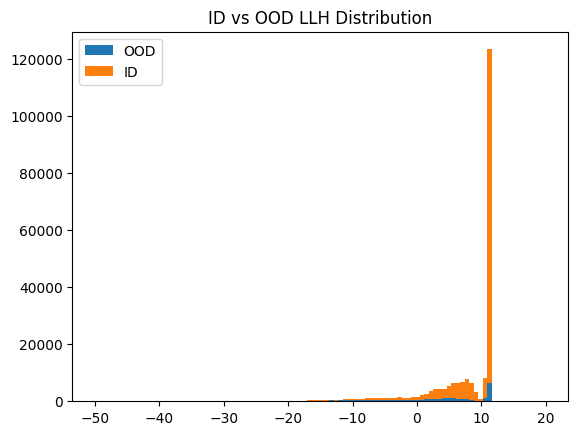

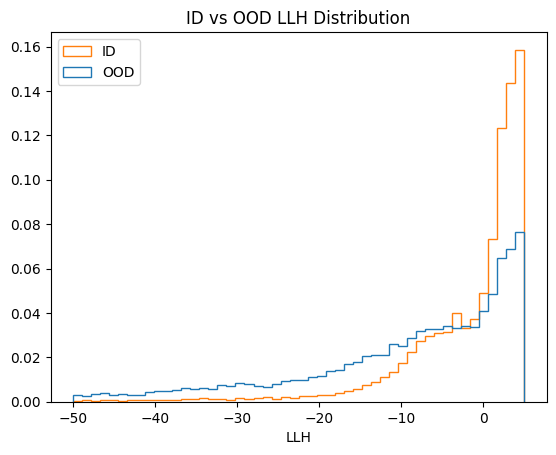

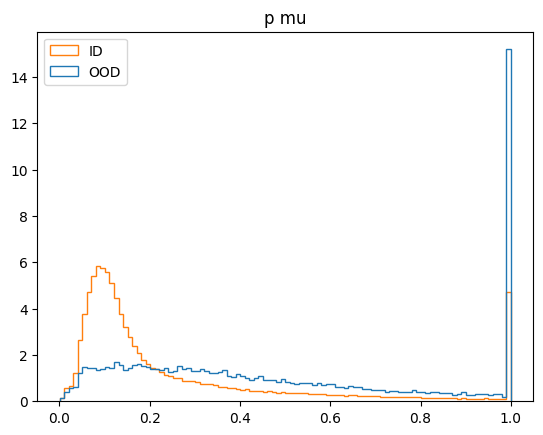

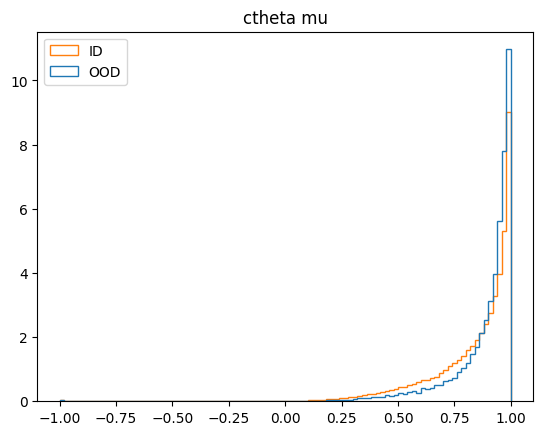

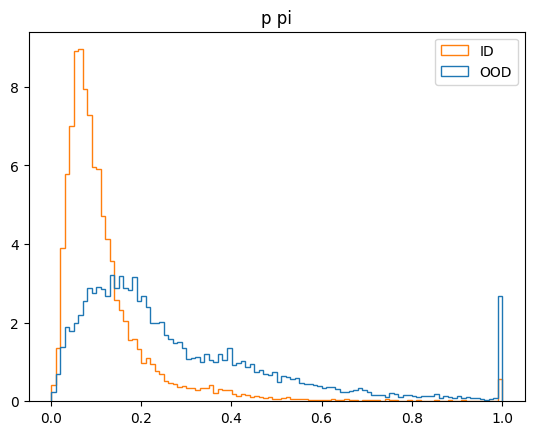

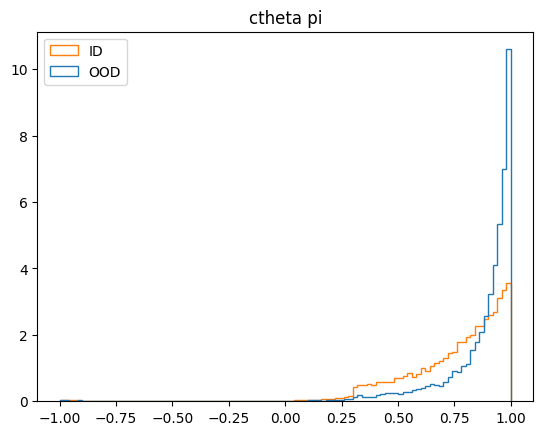

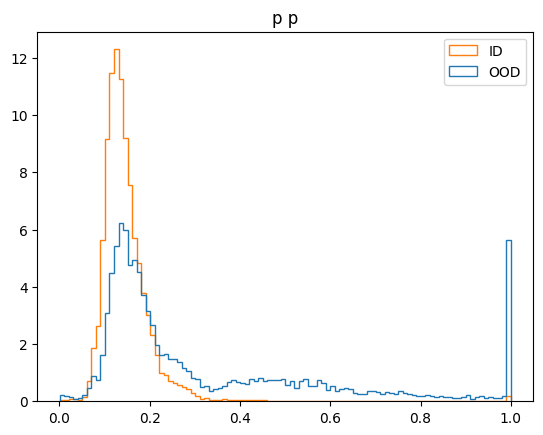

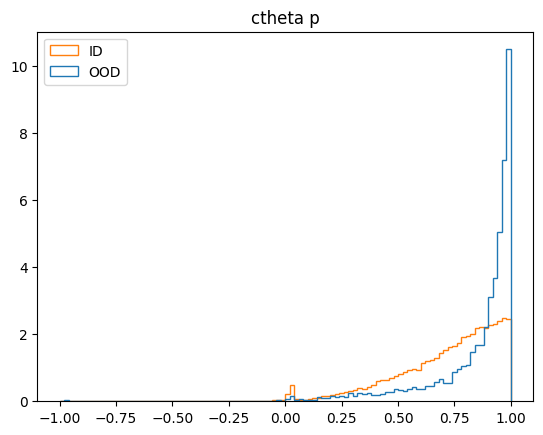

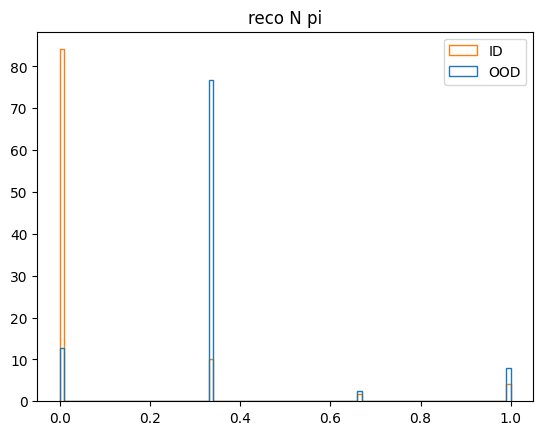

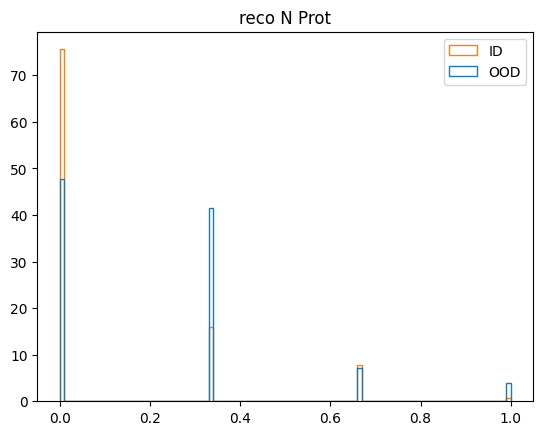

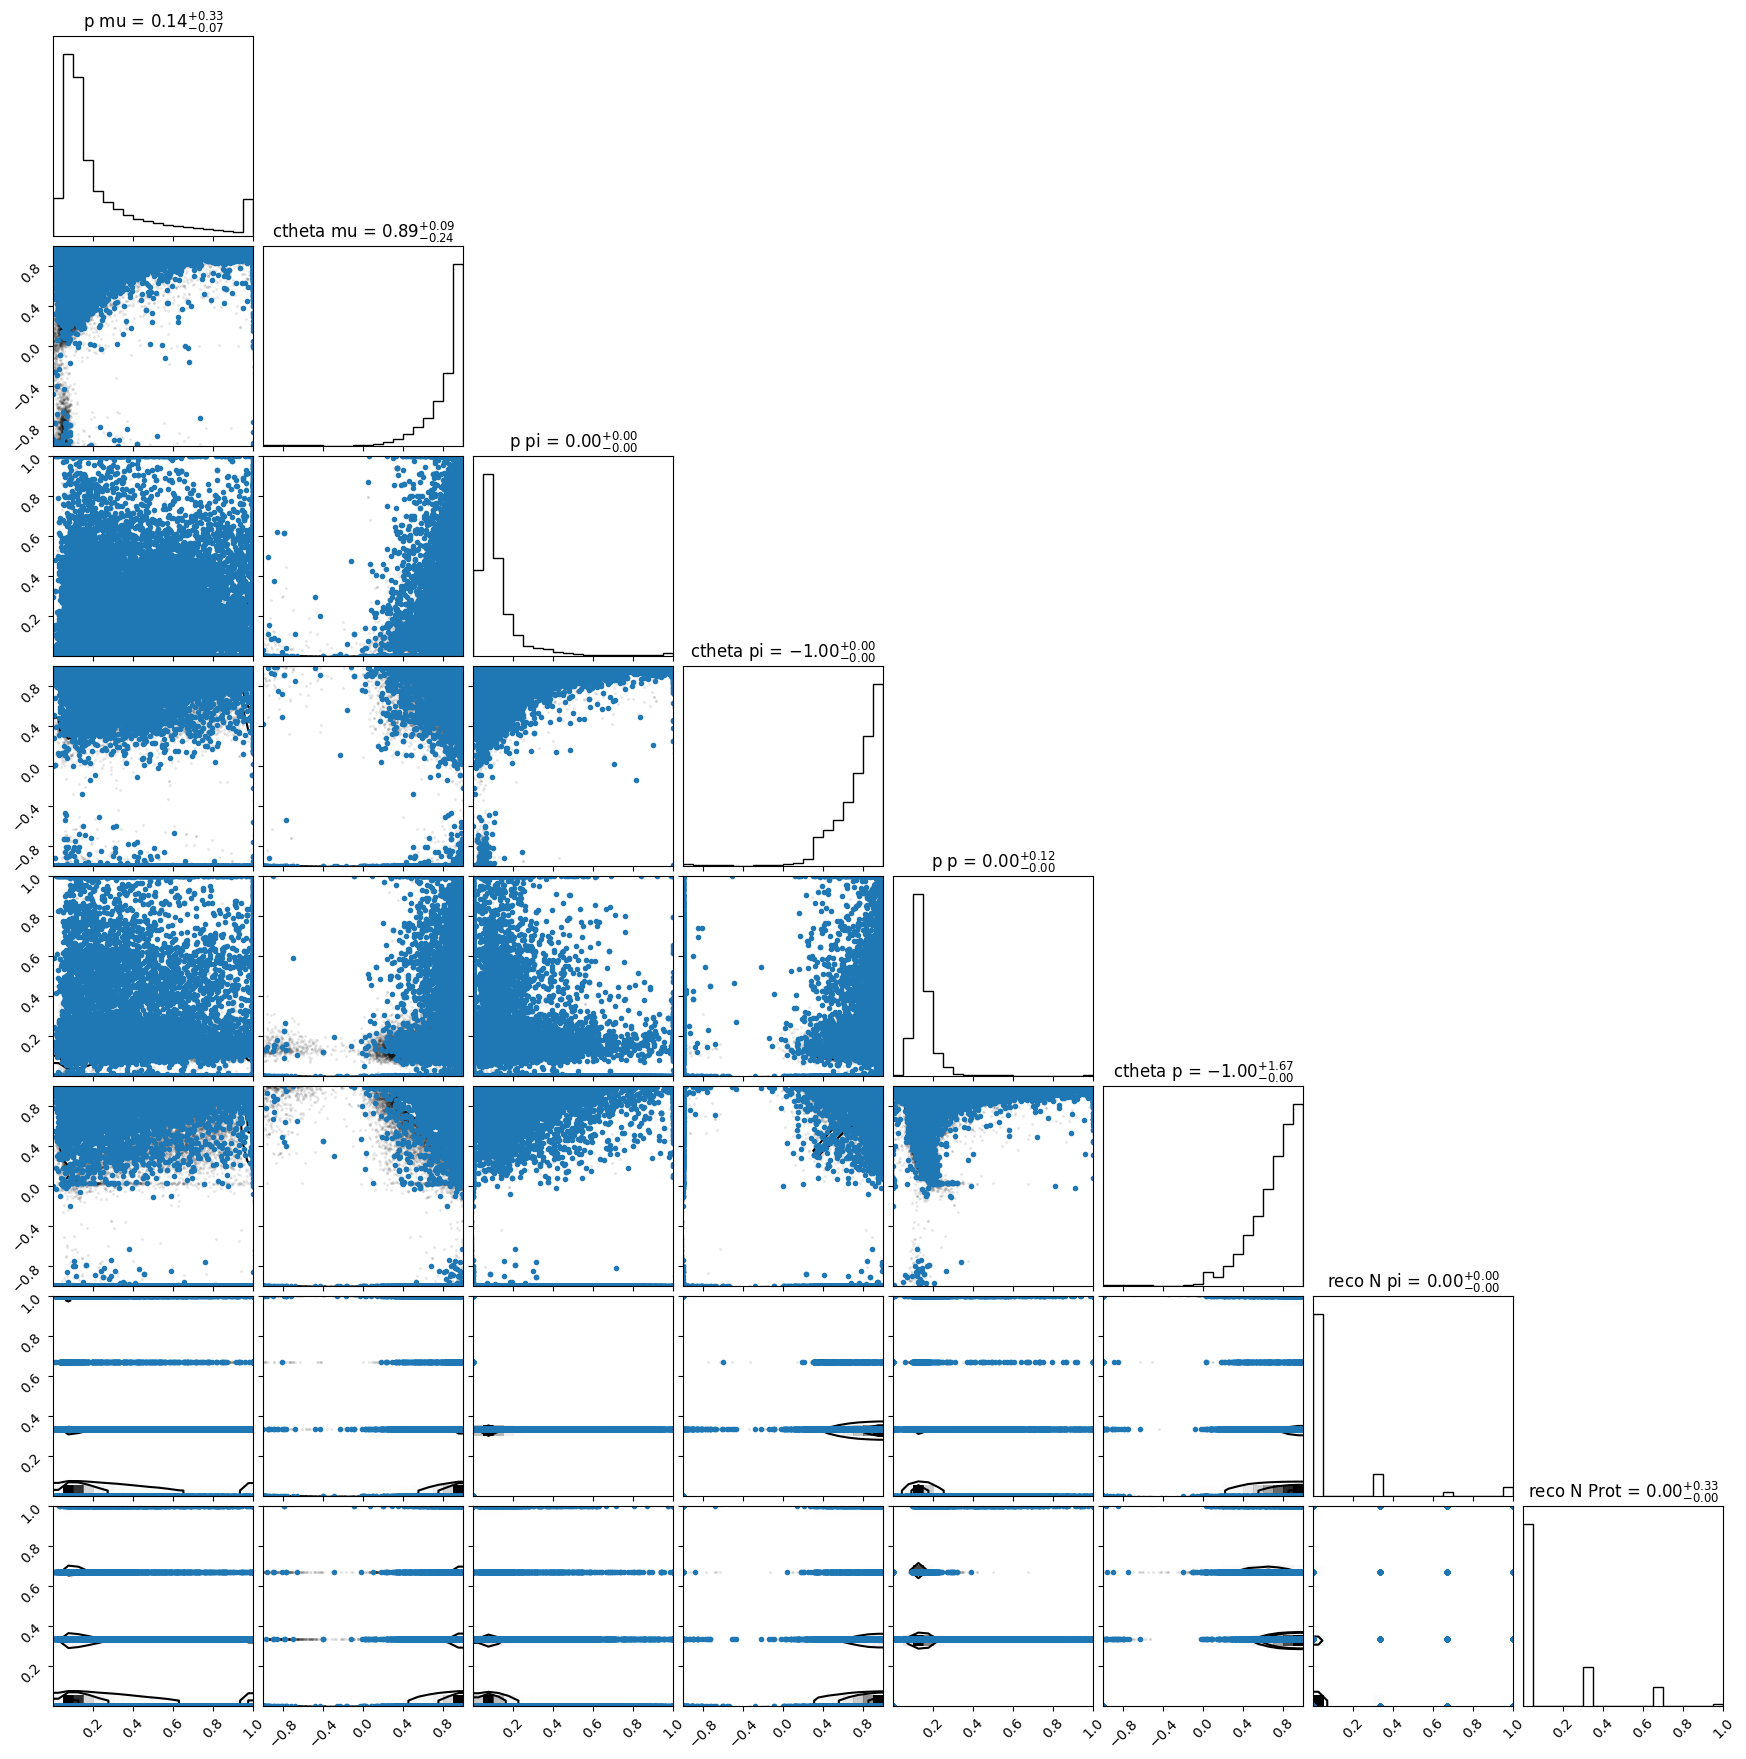

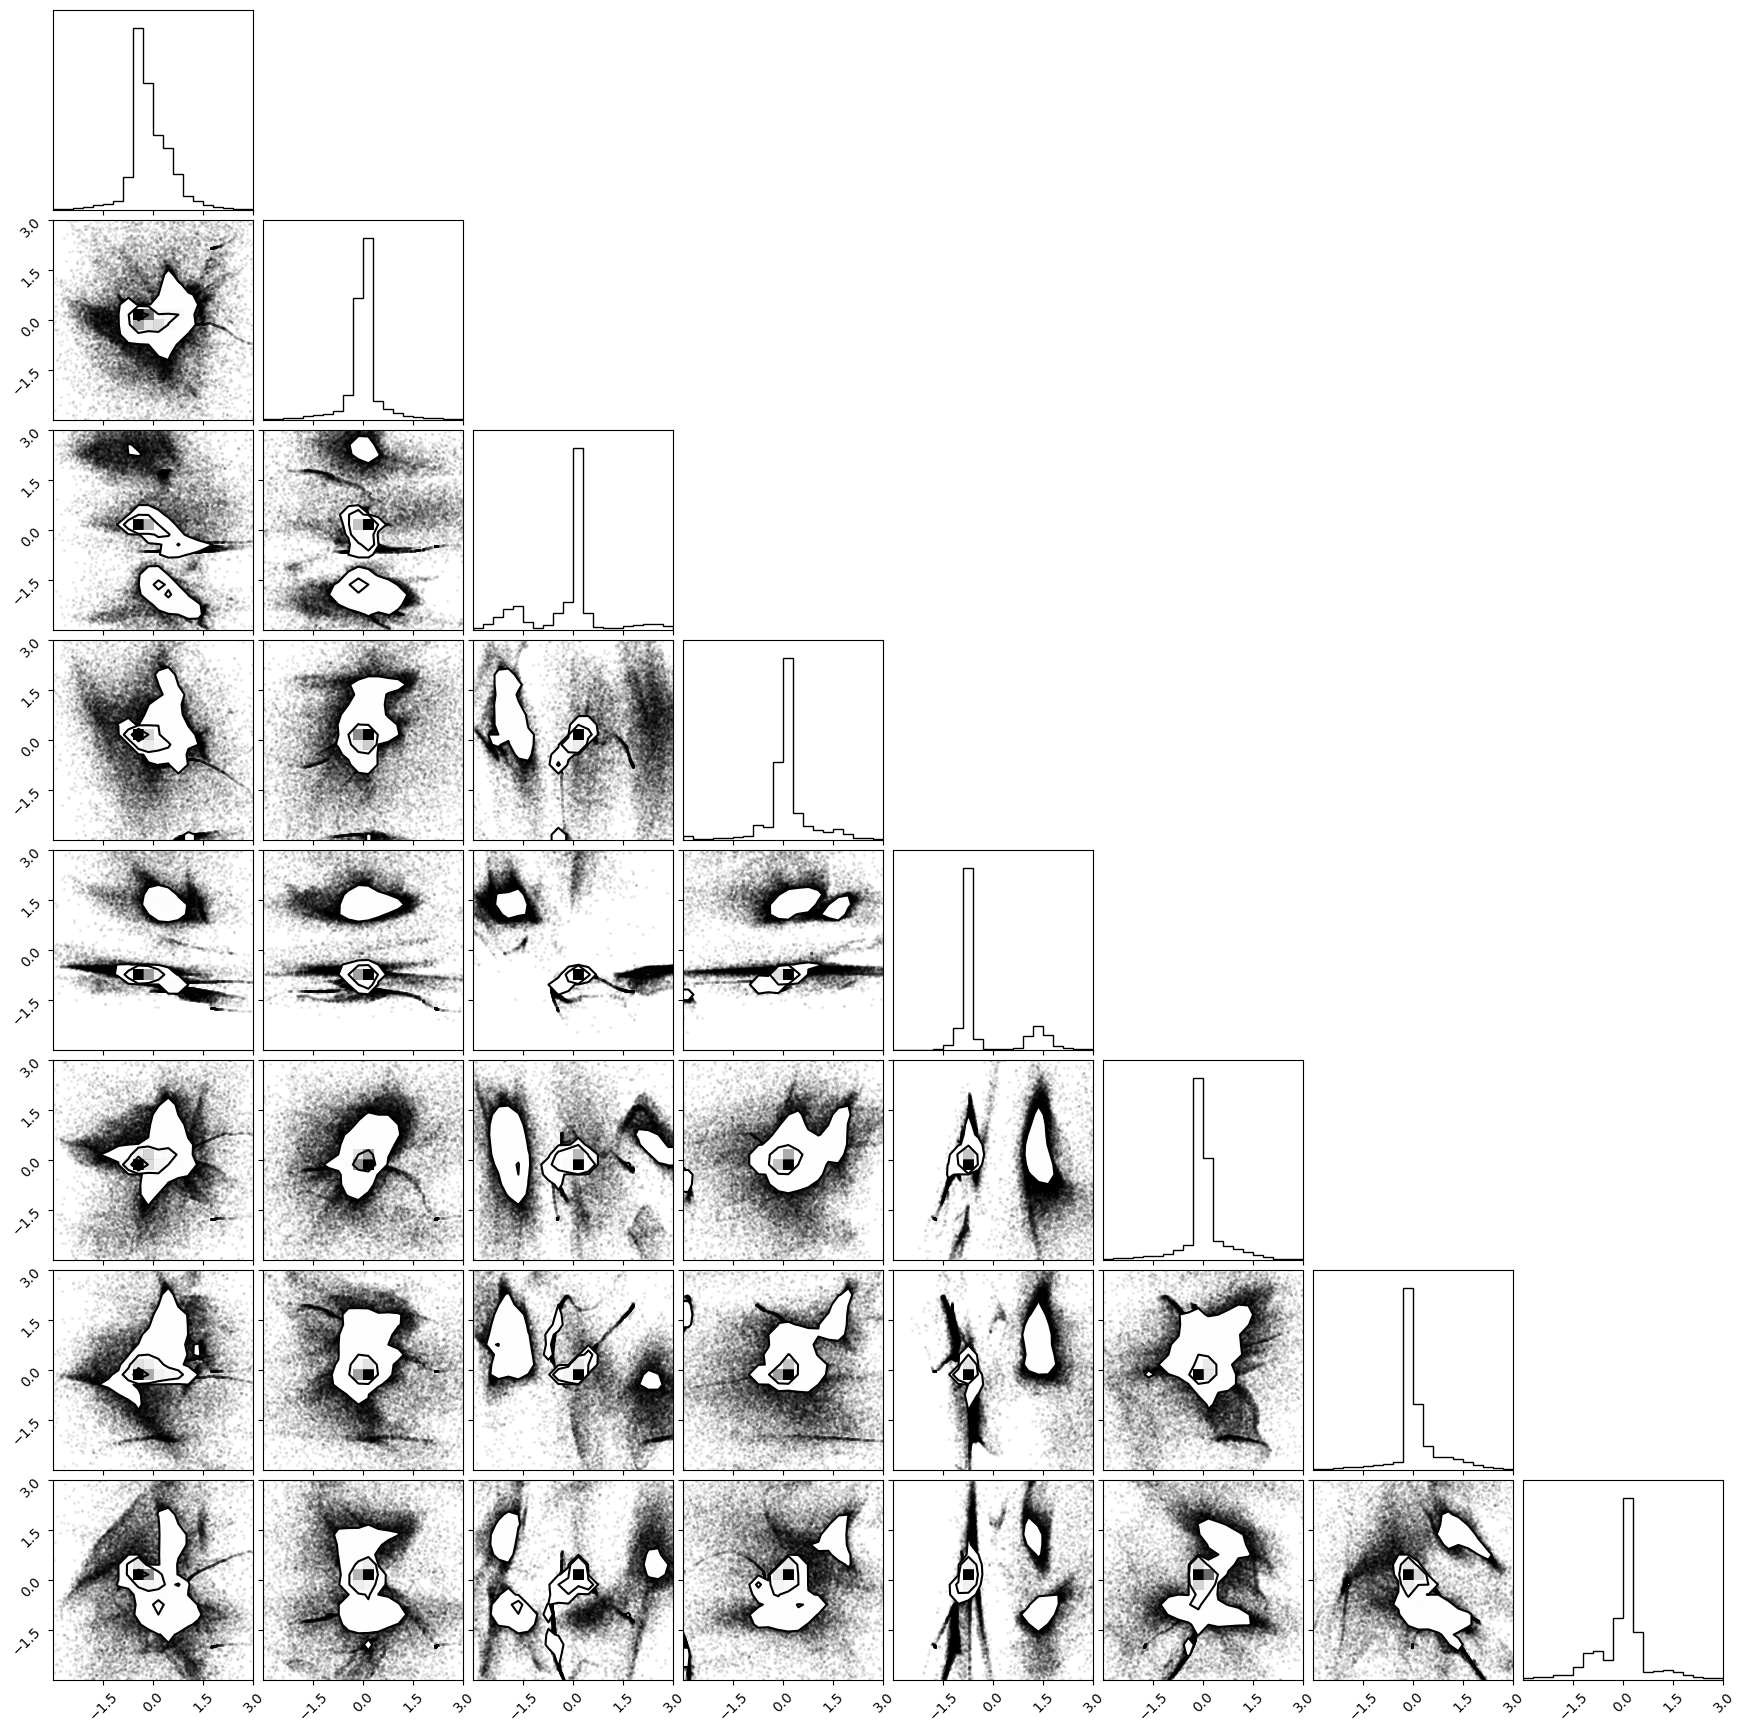

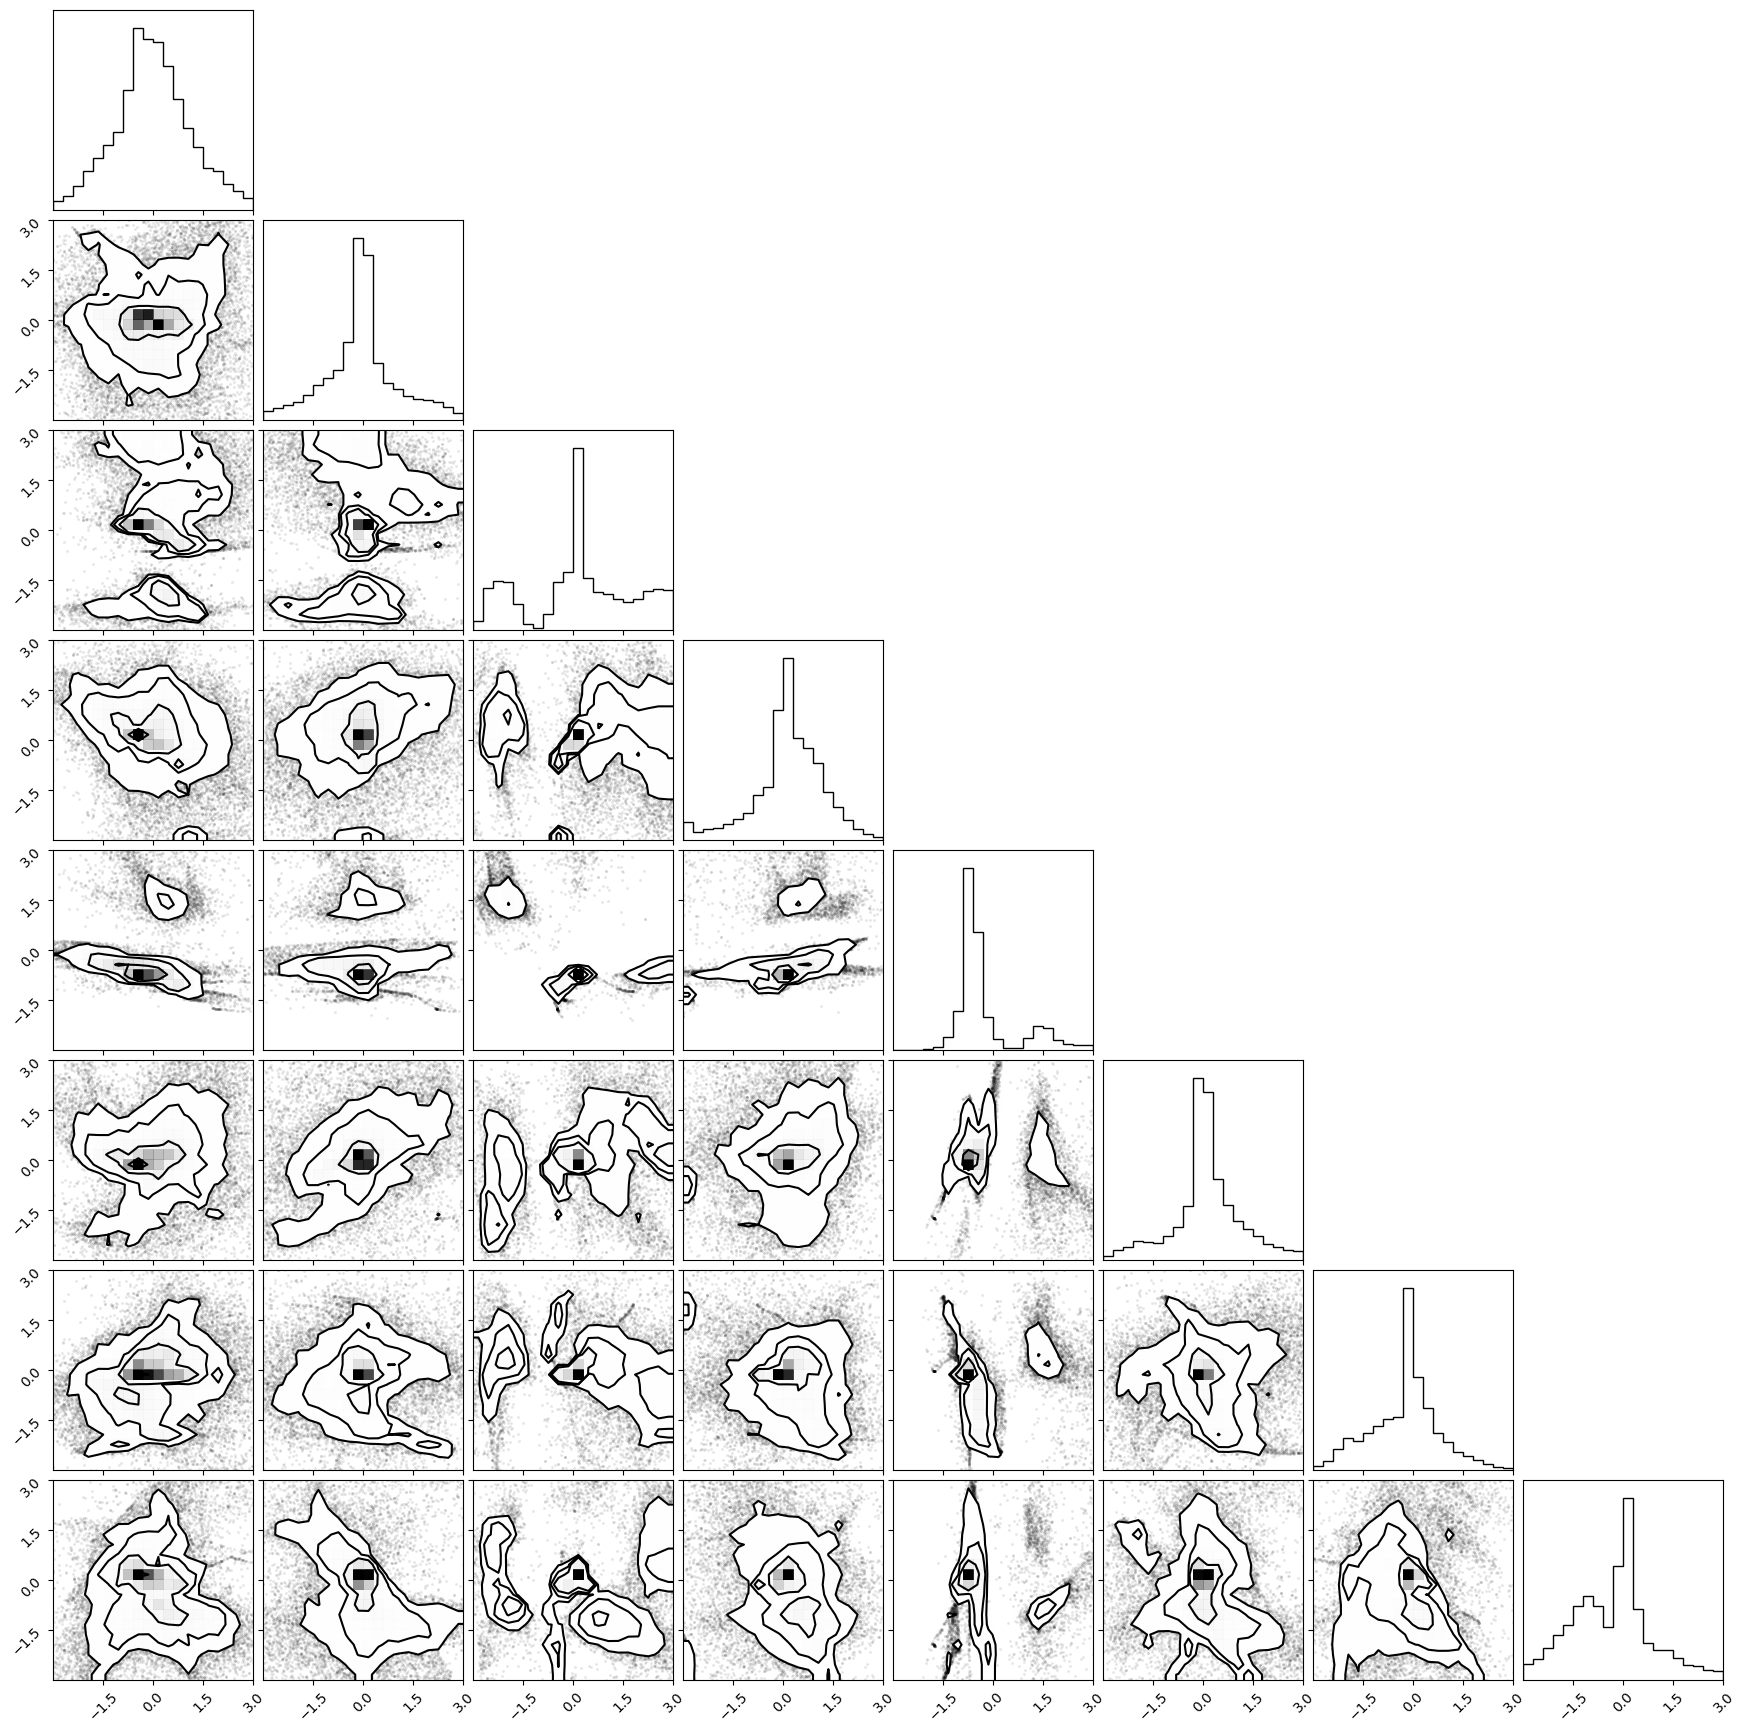

In [13]:
progressbar = tqdm(enumerate(train_loader), total=len(train_loader)) 

raw_dist = np.ndarray((1, n_features))
ood_raw_dist = np.ndarray((1, n_features))
ood_dist = np.ndarray((1, n_features))
enc_dist = np.ndarray((1, n_features))

id_llh = np.ndarray((1, 1))
ood_llh = np.ndarray((1, 1))

if isinstance(model, nf.NormalizingFlowVAE):
    for batch_n, (x, n) in progressbar:
        x = x.to(device)
        encoded, log_q, log_p = model(x, num_samples)
        decoded = model.decoder(encoded)
        plt.scatter(x[:,0].detach(),decoded[:,0,0].detach(), c=[0.2, 0.4, 0.8, 0.3], s=0.2) #encoded[:, 0, 0].detach(), encoded[:, 0, 1].detach()
        progressbar.update()


if isinstance(model, VAE):
    for batch_n, (x, n) in progressbar:
        x = x.to(device)
        encoded = model.encode(x)
        plt.scatter(x[:, 1].detach(), encoded[:, 1].detach(), c=[0.2, 0.4, 0.8, 0.3], s=0.2)
        progressbar.update()


if isinstance(model, NICEModel):
    progressbar = tqdm(enumerate(train_loader), total=len(train_loader))

    for batch_n, (x, n) in progressbar:
        x = x.to(device)
        raw_dist = np.concatenate((raw_dist, x.detach()), axis=0)
        encoded = model(x)
        enc_dist = np.concatenate((enc_dist, encoded.detach()), axis=0)
        id_llh = np.concatenate((id_llh, NICE_gaussian_loss(encoded.detach(), model.scaling_diag.detach(), keepdim=True)), axis=0)
        progressbar.update()


    progressbar = tqdm(enumerate(ood_loader), total=len(ood_loader)-1)

    for batch_n, (x, n) in progressbar:
        x = x.to(device)
        ood_raw_dist = np.concatenate((ood_raw_dist, x.detach()), axis=0)
        encoded = model(x)
        ood_dist = np.concatenate((ood_dist, encoded.detach()), axis=0)
        ood_llh = np.concatenate((ood_llh, NICE_gaussian_loss(encoded.detach(), model.scaling_diag.detach(), keepdim=True)), axis=0)
        progressbar.update()

plt.hist([ood_llh[:,0], id_llh[:,0]], bins=100, range=(-50, 20), stacked=True, label=["OOD", "ID"])
plt.title("ID vs OOD LLH Distribution")
plt.legend()
plt.show()

plt.hist([ood_llh[:,0], id_llh[:,0]], bins=50, range=(-50, 5), histtype='step', label=["OOD", "ID"], density=True, fill=False)
plt.title("ID vs OOD LLH Distribution")
plt.xlabel("LLH")
plt.legend()
plt.show()

LLH_CUT = 5.0
feat_names = ["p mu", "ctheta mu", "p pi", "ctheta pi", "p p", "ctheta p", "reco N pi", "reco N Prot"]
feat_ranges = [(0.001, 1), (-0.999,1), (0.001, 1), (-0.999,1), (0.001, 1), (-0.999,1), (0, 1.0), (0, 1.0)]
far_outliers = ood_llh[:, 0] < LLH_CUT

for feat_id in range(n_features):
    plt.hist([ood_raw_dist[far_outliers, feat_id], raw_dist[:, feat_id]], histtype='step', label=["OOD", "ID"], range=feat_ranges[feat_id], bins=100, density=True, fill=False)
    plt.title(feat_names[feat_id])
    plt.legend()
    plt.show()

figure = corner.corner(
    raw_dist,  
    range = feat_ranges,
    titles = feat_names,
    show_titles = True,
    plot_contours = True,
    hist2d_kwargs = {"no_fill_contours": True}
)
corner.overplot_points(figure, ood_raw_dist[far_outliers, :])
plt.show()

figure = corner.corner(
    enc_dist, 
    range = [(-3, 3), (-3, 3), (-3, 3), (-3, 3), (-3, 3), (-3, 3), (-3, 3), (-3, 3)],
    plot_contours = True,
    hist2d_kwargs = {"no_fill_contours": True}
)
plt.show()

figure = corner.corner(
    ood_dist, 
    range = [(-3, 3), (-3, 3), (-3, 3), (-3, 3), (-3, 3), (-3, 3), (-3, 3), (-3, 3)],
    plot_contours = True,
    hist2d_kwargs = {"no_fill_contours": True})

plt.show()

corner.overplot_points(figure, ood_dist)
plt.show()


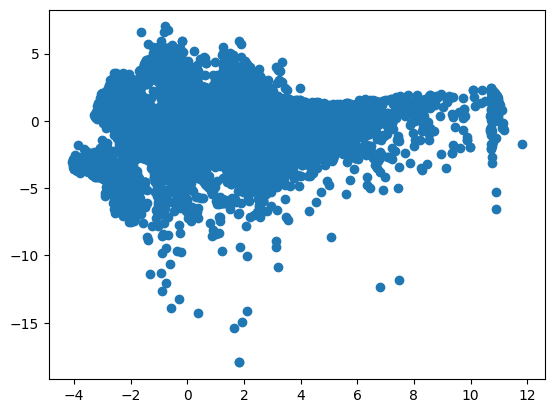

In [14]:
plt.scatter(enc_dist[:, 2], enc_dist[:, 3])
plt.show()